In [1]:
import os
import requests
import pandas as pd
import numpy as np
import healpy as hp
import subprocess as sp
import ligo.skymap.plot
import matplotlib.pyplot as plt
from datetime import datetime
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit
from tiling import get_time_radius
from ligo.skymap.io import read_sky_map, fits
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [2]:
u_triggers = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/u_triggers.csv"))
u_triggers_with_prob = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/u_triggers_with_probs.csv"))
all_grbs = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/all_grbs.csv"))
all_triggers = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/all_triggers.csv"))
print("Total number of triggers: ", len(u_triggers))
u_triggers_with_link = len(u_triggers[u_triggers['url']!='None'])
print("Total number of triggers with link to some data products: ", u_triggers_with_link)
print("Total number of triggers that have some sort of probability map: ", len(u_triggers_with_prob))
print("Total number of triggers that have healpix map: ", len(u_triggers_with_prob[u_triggers_with_prob['healpix']==0]))
print("Total number of triggers that have locprob (old) map: ", len(u_triggers_with_prob[u_triggers_with_prob['locprob']==0]))
print("Total number of triggers that have both maps: ", len(u_triggers_with_prob[(u_triggers_with_prob['healpix']==0) & (u_triggers_with_prob['locprob']==0)]))
print("Total number of GRBs confirmed by Fermi: ", len(all_grbs))
real_grbs = all_grbs['trigger_name'].values
triggers_with_prob = u_triggers_with_prob['GRBName'].values
grb_with_prob = np.intersect1d(real_grbs, triggers_with_prob)
real_grb_triggers = []
for real_grb in real_grbs:
    real_grb_triggers.append(np.unique(u_triggers[u_triggers['url'].str.contains(real_grb)]['trigger_no'].values))
real_grb_triggers = np.concatenate(real_grb_triggers)
real_grb_triggers_with_prob = np.intersect1d(real_grb_triggers, u_triggers_with_prob['Trig_no'].values)
grb_with_link = np.intersect1d(real_grb_triggers, u_triggers['trigger_no'].values)
print("Total number of real GRBs with link to some data products: ", len(grb_with_link))
print("Total number of real GRBs that have corresponding probability maps: ", len(grb_with_prob))
print(np.setdiff1d(real_grbs, triggers_with_prob),"\nThe above GRBs do not have probability maps")
long_grbs = np.unique(all_triggers[all_triggers['Comments'].str.contains("Long GRB")]['TrigNum'].values)
actual_long_grb = np.intersect1d(long_grbs, real_grb_triggers)
actual_long_grb_with_prob = np.intersect1d(long_grbs, real_grb_triggers_with_prob)
short_grbs = np.unique(all_triggers[all_triggers['Comments'].str.contains("Short GRB")]['TrigNum'].values)
actual_short_grb = np.intersect1d(short_grbs, real_grb_triggers)
actual_short_grb_with_prob = np.intersect1d(short_grbs, real_grb_triggers_with_prob)
print("Total number of triggers reported as likely Long GRBs: ", len(long_grbs))
print("Out of the these, the number of real GRBs: ", len(actual_long_grb))
print("Out of the these, the number of real GRBs that have probability maps: ", len(actual_long_grb_with_prob))
print("Total number of triggers reported as likely Short GRBs: ", len(short_grbs))
print("Out of the these, the number of real GRBs: ", len(actual_short_grb))
print("Out of the these, the number of real GRBs that have probability maps: ", len(actual_short_grb_with_prob))

Total number of triggers:  3766
Total number of triggers with link to some data products:  3760
Total number of triggers that have some sort of probability map:  1761
Total number of triggers that have healpix map:  1409
Total number of triggers that have locprob (old) map:  1652
Total number of triggers that have both maps:  1301
Total number of GRBs confirmed by Fermi:  1603
Total number of real GRBs with link to some data products:  1546
Total number of real GRBs that have corresponding probability maps:  1499
['bn170307851' 'bn170430204' 'bn170614505' 'bn170626401' 'bn170726794'
 'bn170926782' 'bn171010875' 'bn171120556' 'bn171212948' 'bn171222684'
 'bn180204109' 'bn180205184' 'bn180618030' 'bn180620660' 'bn180706351'
 'bn180917477' 'bn181016718' 'bn181125371' 'bn181126413' 'bn181225489'
 'bn190109497' 'bn190123513' 'bn190311600' 'bn190323548' 'bn190427190'
 'bn190531568' 'bn190716019' 'bn190821716' 'bn191119261' 'bn191130507'
 'bn200224416' 'bn200416295' 'bn200630076' 'bn200829582

# **Full Night**

In [3]:
coverage = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/coverage.csv"))
filt = ['DID NOT RISE', 'None', 'NOT VISIBLE']
select = [value not in [filt[0], filt[1]] for value in coverage['coverage'].values]
total_maps_tiled = len(coverage['coverage'][select])
print("Total number of probability maps tiled: ", total_maps_tiled)
print(f"Total time taken:  25000 seconds ~ {np.round(25000/total_maps_tiled, 2)} seconds per map")

Total number of probability maps tiled:  996
Total time taken:  25000 seconds ~ 25.1 seconds per map


In [4]:
PIX_AREA = hp.nside2pixarea(128, degrees=True)
def get_loc_size(healpix, frac=0.9):
    hpmap = read_sky_map(healpix)[0]
    sortorder = np.argsort(hpmap)[::-1]
    n_pix = len(sortorder[:np.where(np.cumsum(hpmap[sortorder])/np.sum(hpmap)>frac)[0][0]])
    return n_pix*PIX_AREA

In [5]:
select = coverage['coverage'].str.contains("(\d+)")
coverage = coverage[select]
select = coverage[select]['radius'].astype(float) < 30
coverage = coverage[select]
coverage['radius'] = coverage['radius'].astype(float)
coverage['coverage'] = coverage['coverage'].astype(float)
coverage = coverage.reset_index(drop=True)

area, tiletime, times =  [], [], []
for (i, heal) in enumerate(coverage['healpix']):
    time = datetime.strptime(coverage['time'][i], "%Y-%m-%d %H:%M:%S")
    file = "/home/ravioli/astro/git/fermi_grbs/data/"+heal
    covragefile = "/home/ravioli/astro/git/fermi_grbs/data/"+heal+"_scheduled.csv"
    tiletime.append(len(pd.DataFrame(pd.read_csv(covragefile)))*5/60)
    area.append(get_loc_size(file, frac=0.5))
    times.append(time)

coverage['area'] = np.array(area).astype(float)
coverage['tiletimes'] = np.array(tiletime).astype(float)
coverage['time'] = np.array(times).astype(datetime)

/home/ravioli/miniconda3/envs/growth/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/ravioli/miniconda3/envs/growth/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


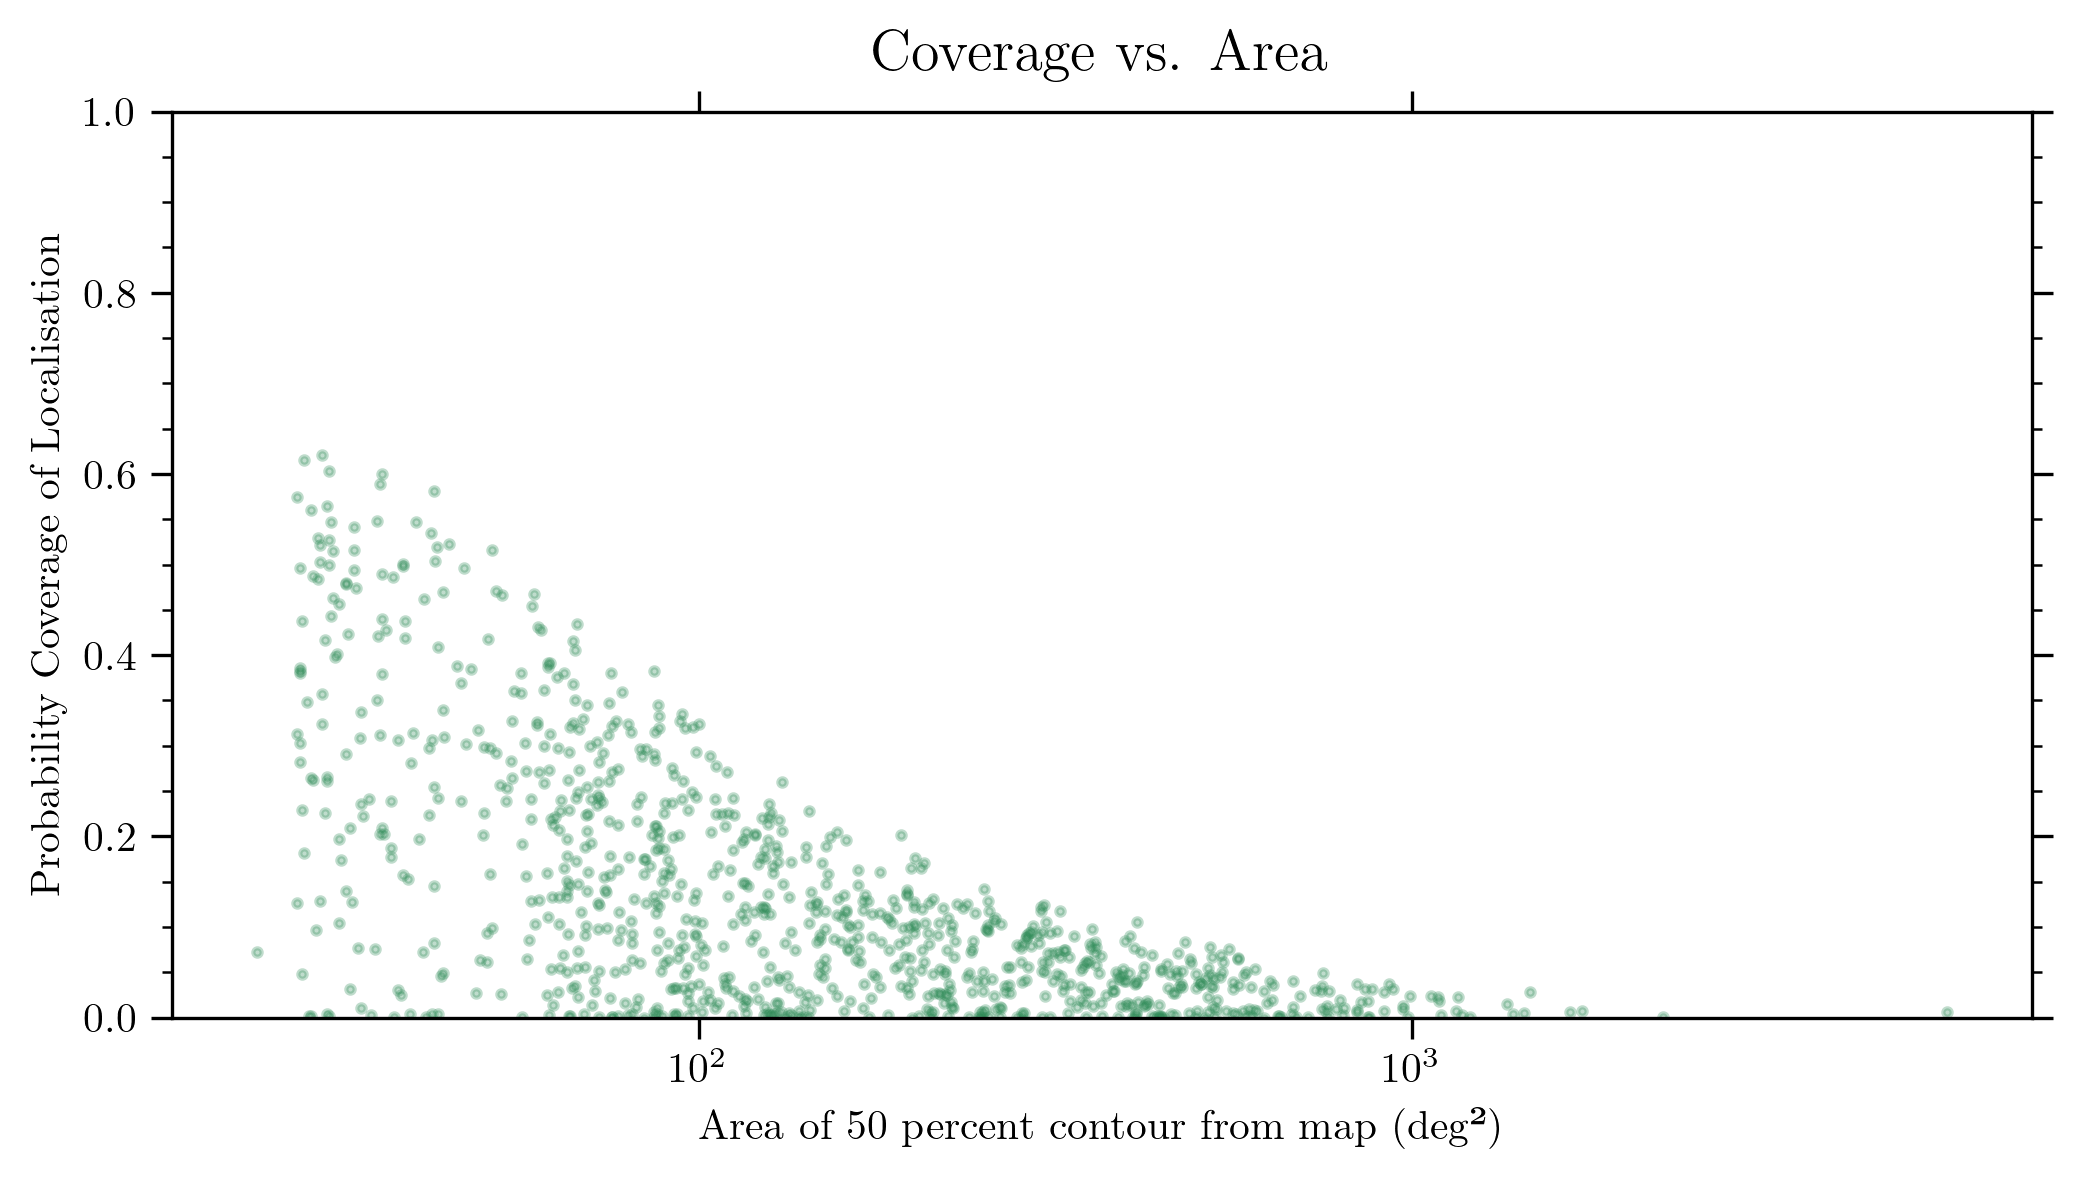

In [6]:
plt.figure(figsize=(8,4), dpi=300)
plt.scatter(coverage['area'], coverage['coverage'], s=4, color='seagreen', alpha=0.3)
# plt.vlines(25, 0, 1, color='k', linestyle='--', linewidth=1, alpha = 0.5)
plt.xlabel("Area of 50 percent contour from map (deg²)")
plt.ylabel("Probability Coverage of Localisation")
plt.title("Coverage vs. Area", fontsize=14, pad=10)
plt.ylim(0,1)
plt.xscale('symlog')
plt.show()

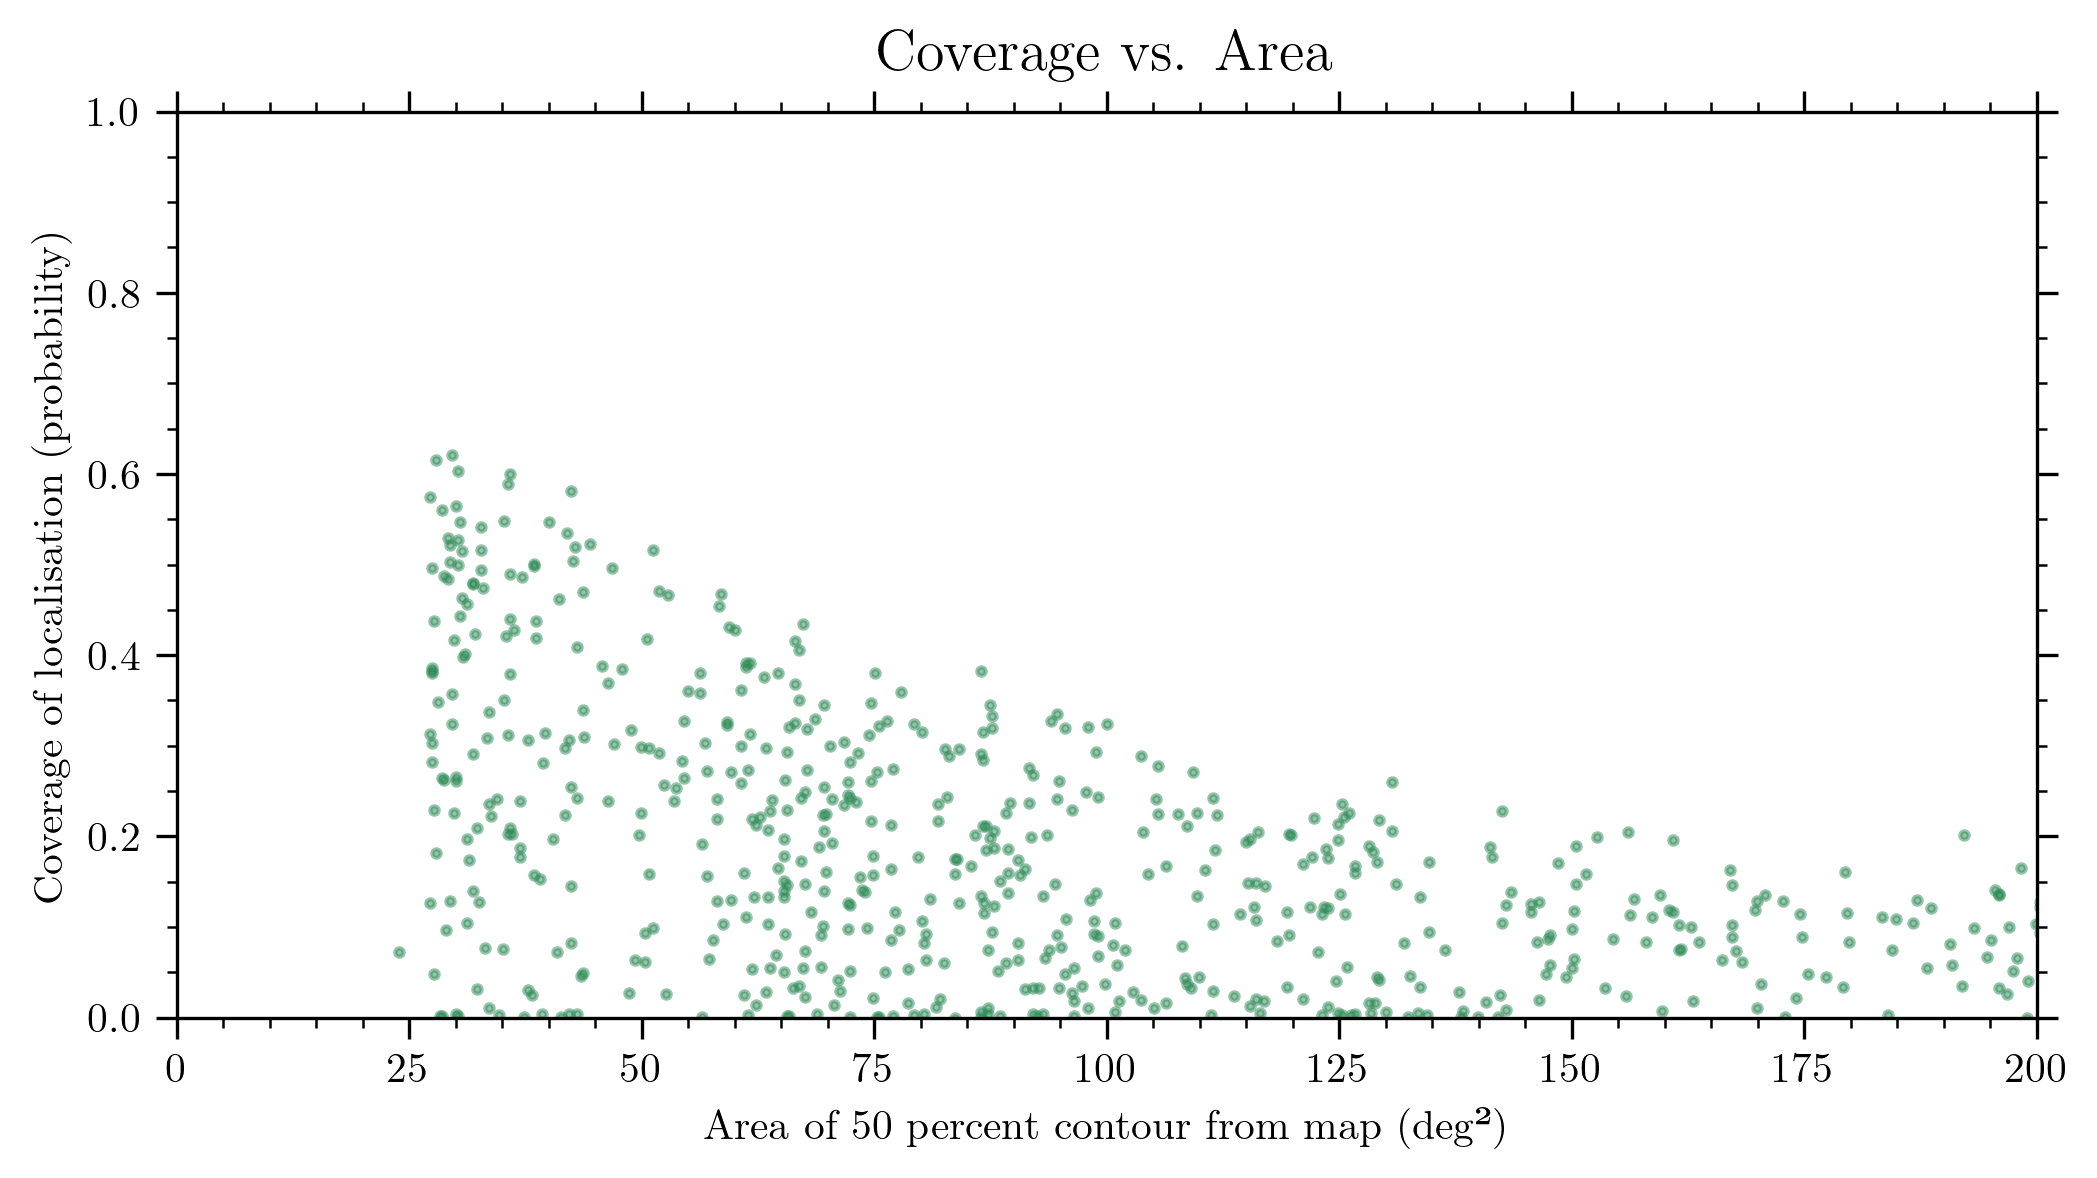

In [7]:
plt.figure(figsize=(8,4), dpi=300)
plt.scatter(coverage['area'], coverage['coverage'], s=4, color='seagreen', alpha=0.5)
plt.xlabel("Area of 50 percent contour from map (deg²)")
plt.ylabel("Coverage of localisation (probability)")
plt.title("Coverage vs. Area", fontsize=14, pad=10)
plt.xlim(0,200)
plt.ylim(0,1)
plt.show()

In [8]:
print(len(coverage[coverage['coverage']>0.2]))

245


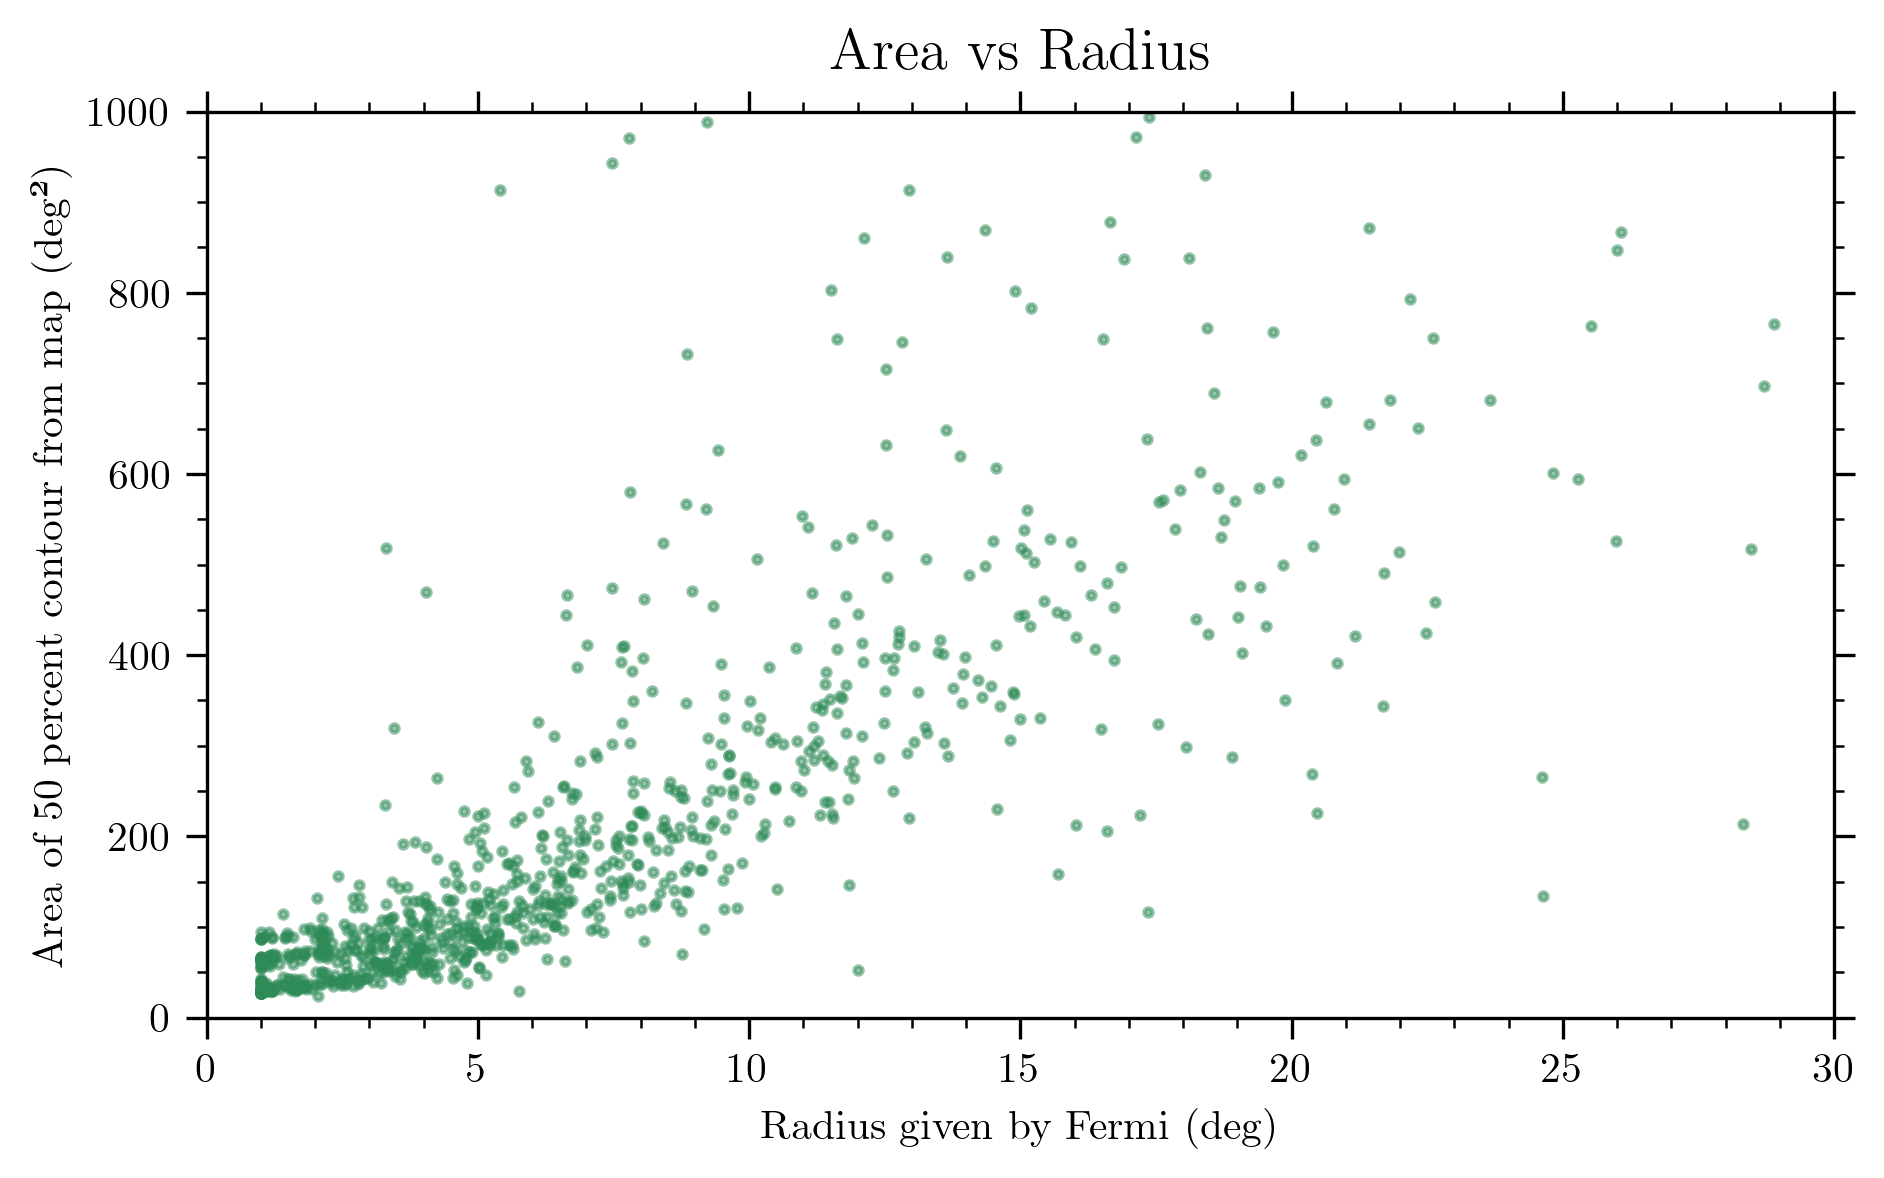

In [9]:
plt.figure(figsize=(7,4), dpi=300)
plt.scatter(coverage['radius'], coverage['area'], s=4, color='seagreen', alpha=0.5)
plt.xlabel("Radius given by Fermi (deg)")
plt.ylabel("Area of 50 percent contour from map (deg²)")
plt.title("Area vs Radius", fontsize=14, pad=10)
plt.ylim(0,1000)
plt.xlim(0,30)
plt.show()

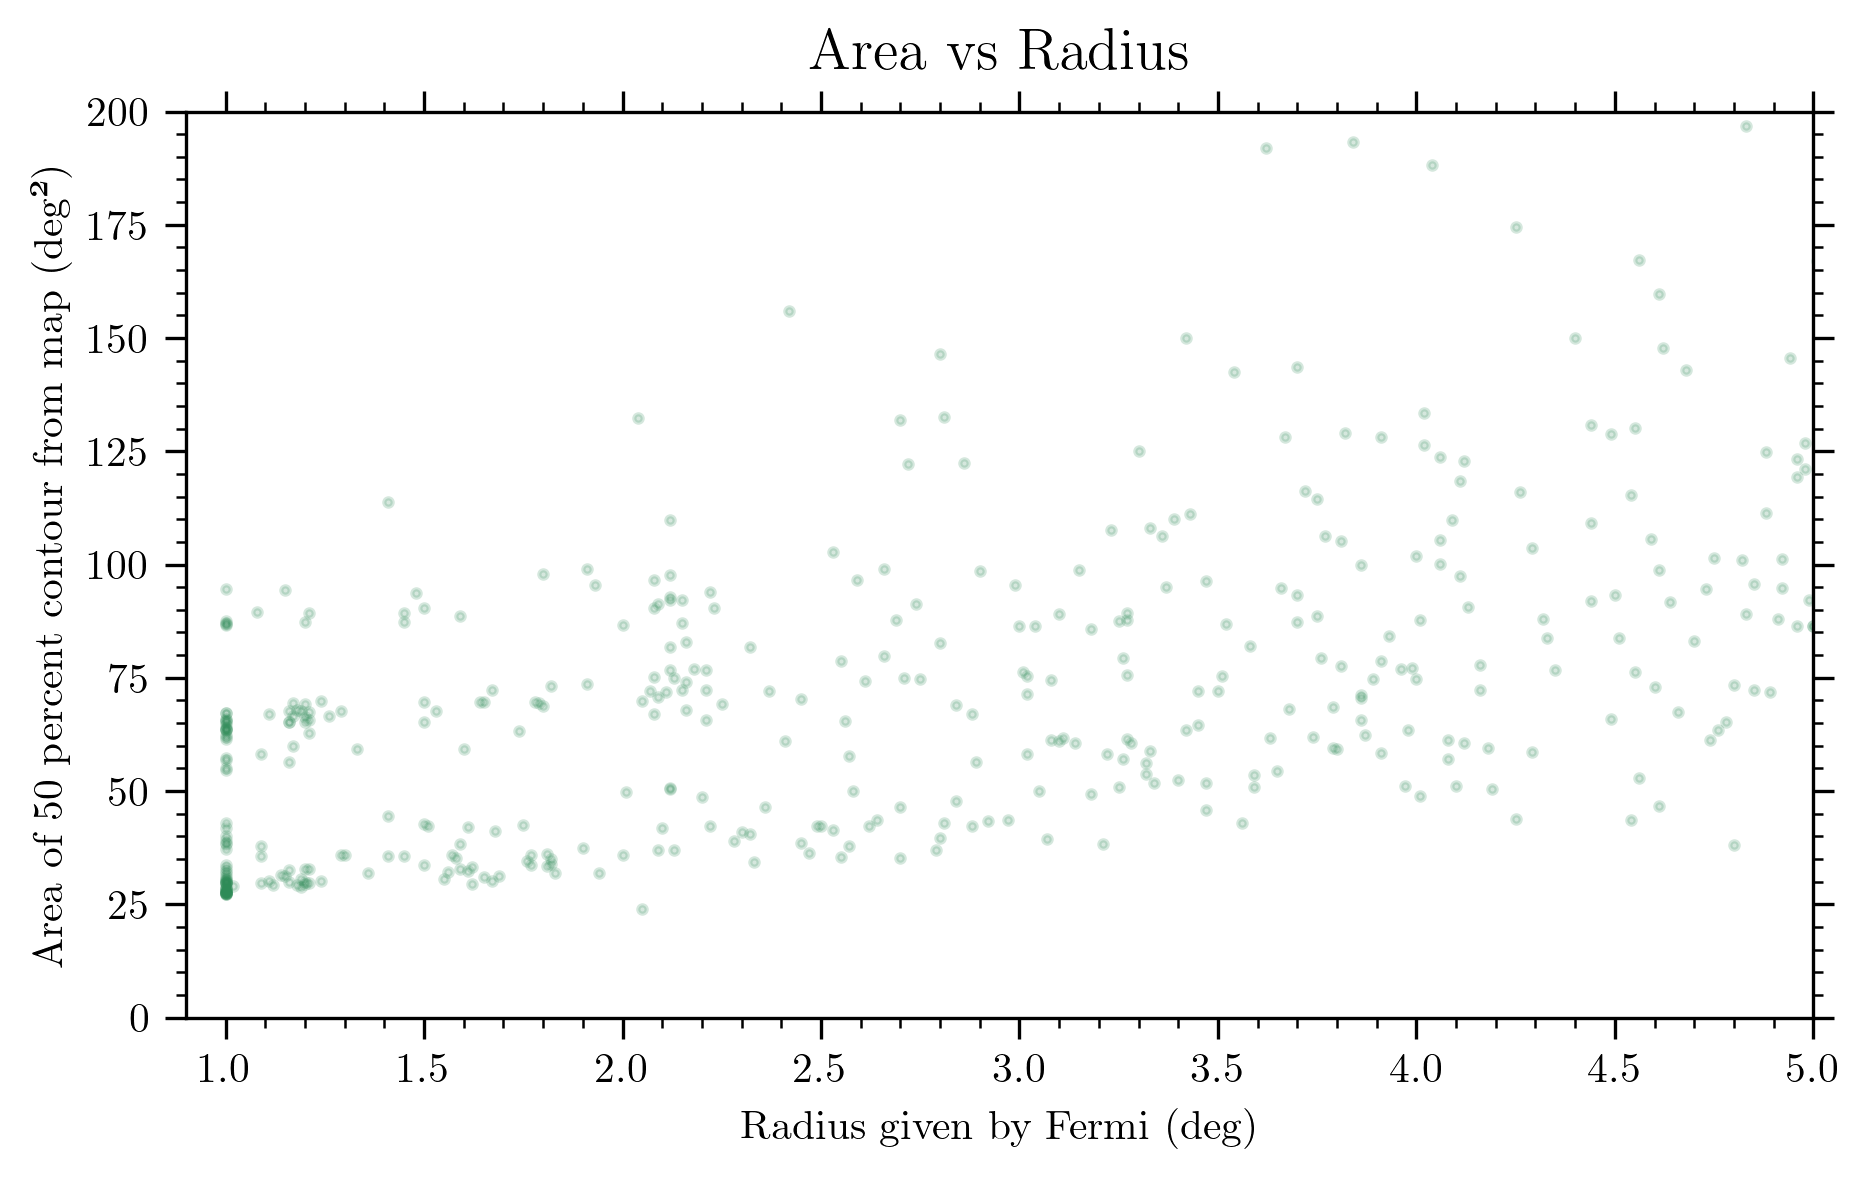

In [10]:
plt.figure(figsize=(7,4), dpi=300)
plt.scatter(coverage['radius'], coverage['area'], s=4, color='seagreen', alpha=0.2)
plt.xlabel("Radius given by Fermi (deg)")
plt.ylabel("Area of 50 percent contour from map (deg²)")
plt.title("Area vs Radius", fontsize=14, pad=10)
plt.ylim(0,200)
plt.xlim(0.9,5)
plt.show()

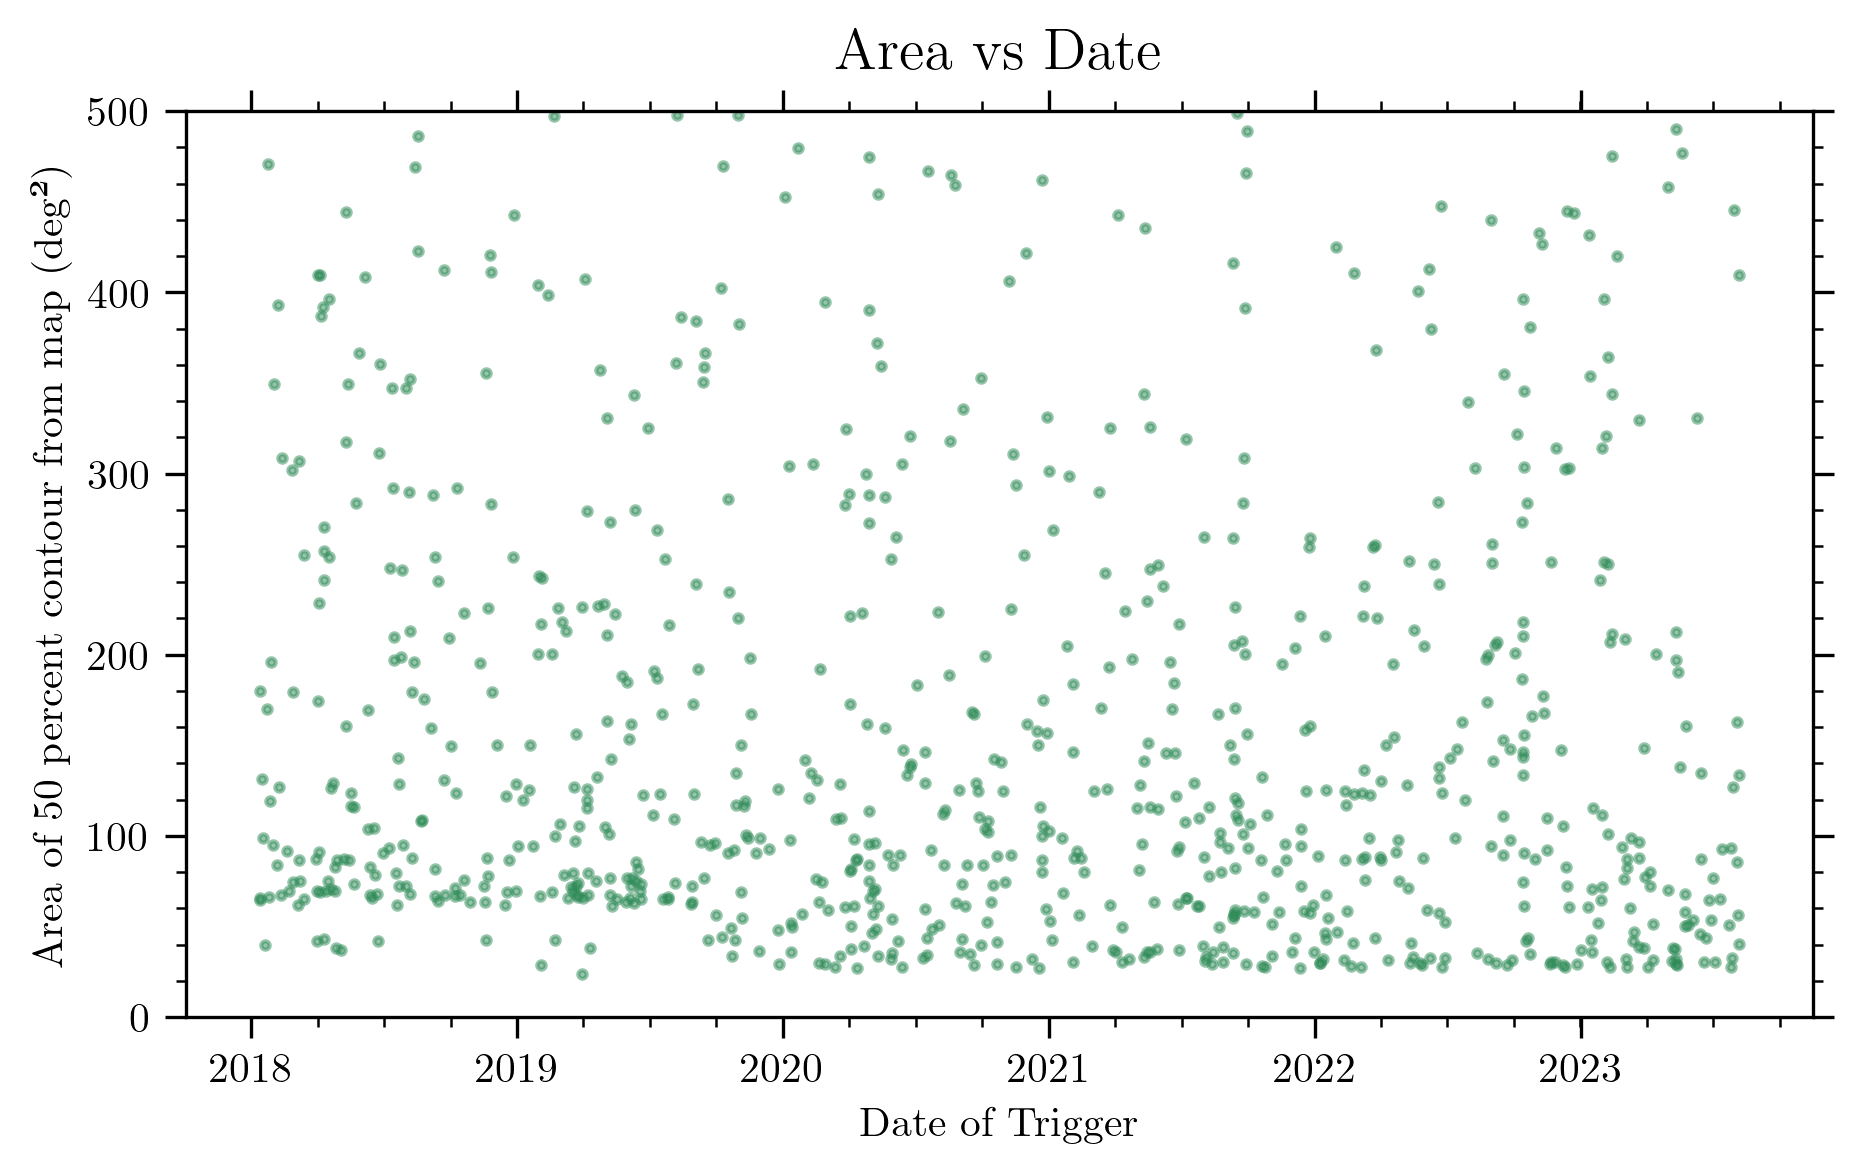

In [11]:
plt.figure(figsize=(7,4), dpi=300)
plt.scatter(coverage['time'], coverage['area'], s=4, color='seagreen', alpha=0.5)
plt.xlabel("Date of Trigger")
plt.ylabel("Area of 50 percent contour from map (deg²)")
plt.title("Area vs Date", fontsize=14, pad=10)
plt.ylim(0,500)
plt.show()

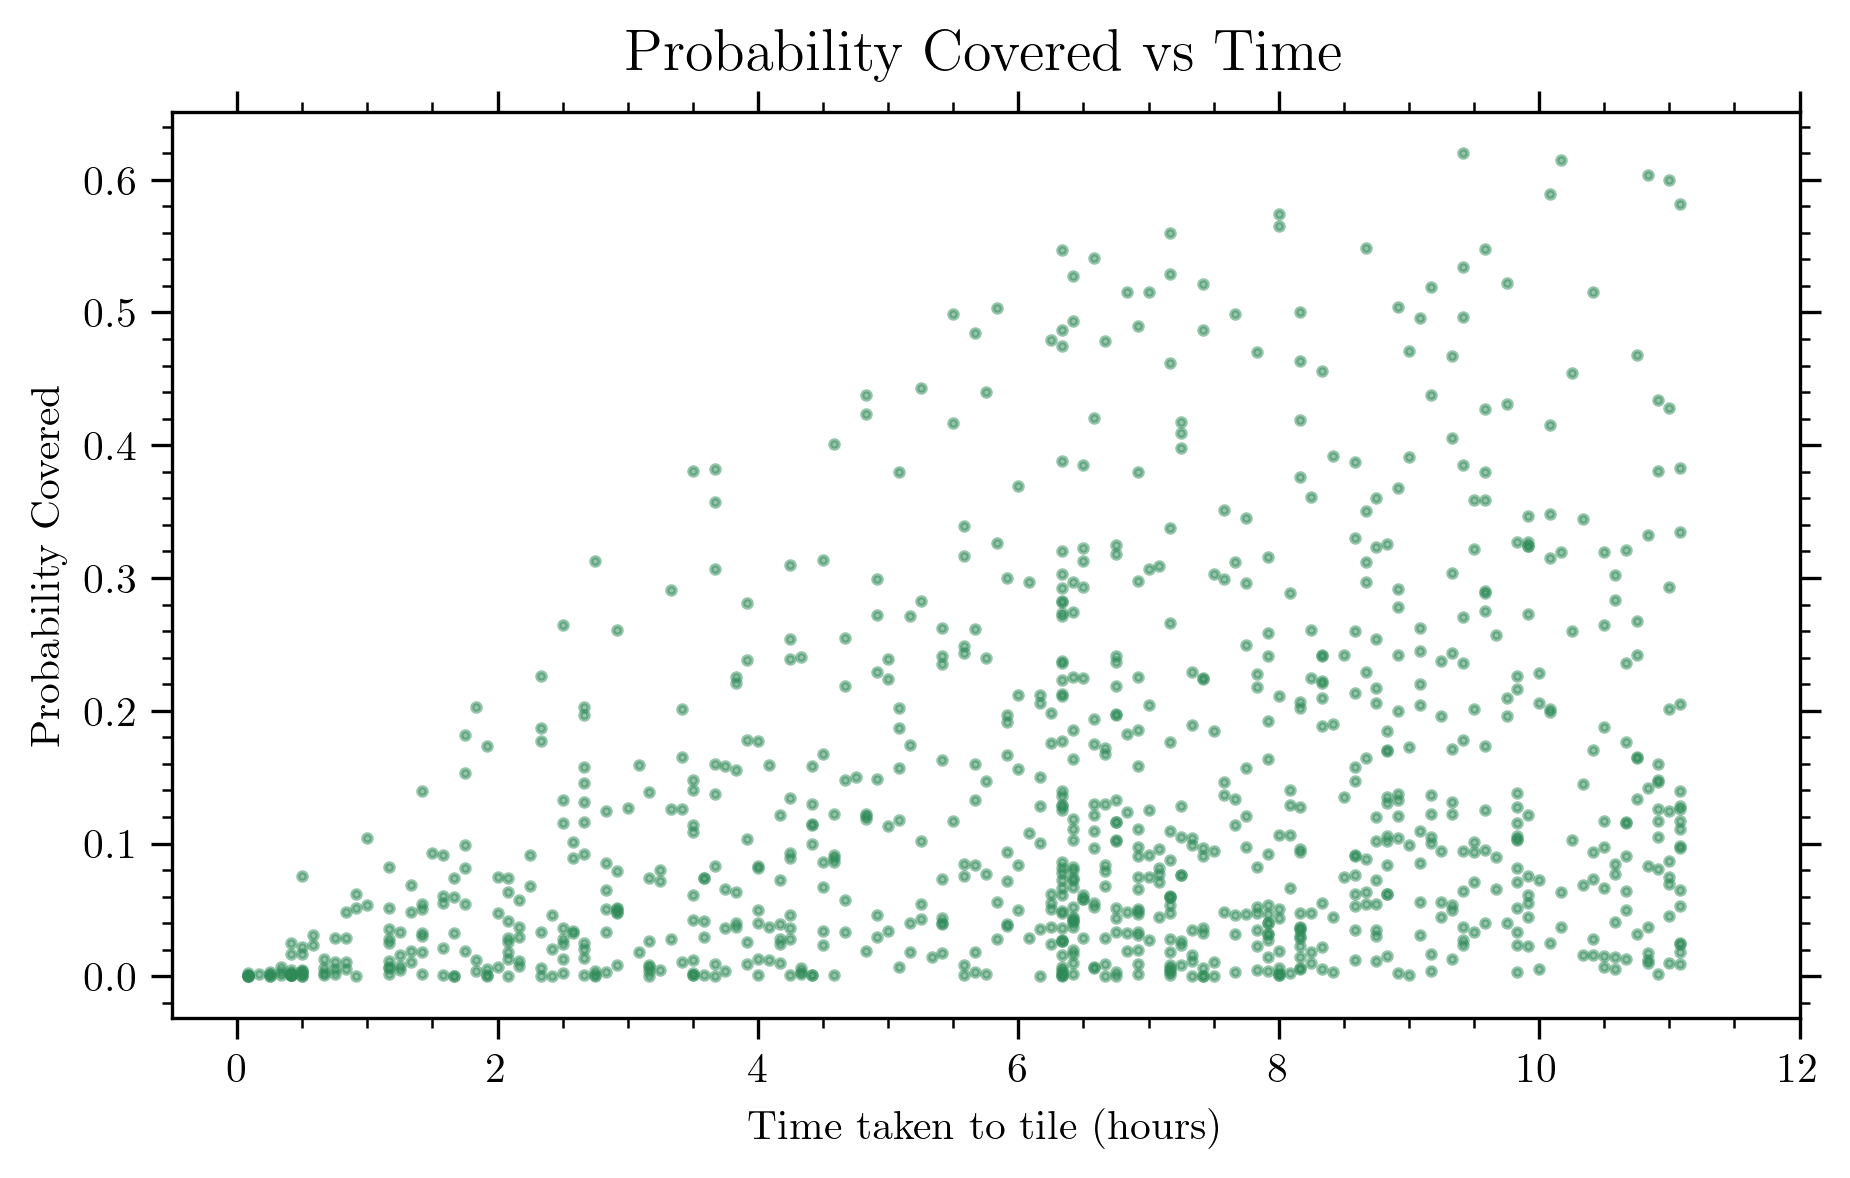

100


In [12]:
plt.figure(figsize=(7,4), dpi=300)
plt.scatter(coverage['tiletimes'], coverage['coverage'], s=4, color='seagreen', alpha=0.5)
plt.xlabel("Time taken to tile (hours)")
plt.ylabel("Probability Covered")
plt.title("Probability Covered vs Time", fontsize=14, pad=10)
plt.xlim(-0.5,12)
plt.show()
print(np.sum(coverage['tiletimes'] < 2))

In [13]:
print("High probab:", np.sum(coverage['coverage'] > 0.3))
print("Small radius: ", np.sum(coverage['radius'] < 6))

High probab: 126
Small radius:  506


In [14]:
for pcut in [0.05, 0.1, 0.15, 0.2]:
    select = coverage['coverage'] > pcut
    n_obs = np.sum(select)
    tobs = np.sum(coverage['tiletimes'][select])
    tot_prob = np.sum(coverage['coverage'][select])
    print(f"{n_obs} GRBs with prob > {pcut:0.2f}, total probab = {tot_prob:0.1f}, tot time = {tobs:0.1f}h, time/grb = {tobs/tot_prob:0.1f}h/grb ")

607 GRBs with prob > 0.05, total probab = 120.9, tot time = 4288.2h, time/grb = 35.5h/grb 
433 GRBs with prob > 0.10, total probab = 108.1, tot time = 3166.7h, time/grb = 29.3h/grb 
314 GRBs with prob > 0.15, total probab = 93.5, tot time = 2317.8h, time/grb = 24.8h/grb 
245 GRBs with prob > 0.20, total probab = 81.4, tot time = 1864.9h, time/grb = 22.9h/grb 


In [15]:
for pcut in [0.05, 0.1, 0.15, 0.2]:
    select = coverage['coverage'] > pcut
    n_obs = np.sum(select)
    tobs = np.sum(coverage['tiletimes'][select])
    tot_prob = np.sum(coverage['coverage'][select])
    print(f">{pcut:0.2f} & {n_obs} & {tot_prob:0.1f} & {tobs:0.1f} & {tobs/tot_prob:0.1f} \\\\")

>0.05 & 607 & 120.9 & 4288.2 & 35.5 \\
>0.10 & 433 & 108.1 & 3166.7 & 29.3 \\
>0.15 & 314 & 93.5 & 2317.8 & 24.8 \\
>0.20 & 245 & 81.4 & 1864.9 & 22.9 \\


In [16]:
for obstime in np.arange(1, 7):
    select = coverage['tiletimes'] < obstime
    tot_prob = np.sum(coverage['coverage'][select])
    tot_time = np.sum(select) * obstime
    print(f"{np.sum(select)} GRBs with obstime < {obstime} hours, total prob = {tot_prob:0.1f}, total time = {tot_time} hours")

50 GRBs with obstime < 1 hours, total prob = 0.5, total time = 50 hours
100 GRBs with obstime < 2 hours, total prob = 3.0, total time = 200 hours
167 GRBs with obstime < 3 hours, total prob = 7.6, total time = 501 hours
227 GRBs with obstime < 4 hours, total prob = 13.7, total time = 908 hours
294 GRBs with obstime < 5 hours, total prob = 21.4, total time = 1470 hours
358 GRBs with obstime < 6 hours, total prob = 32.0, total time = 2148 hours


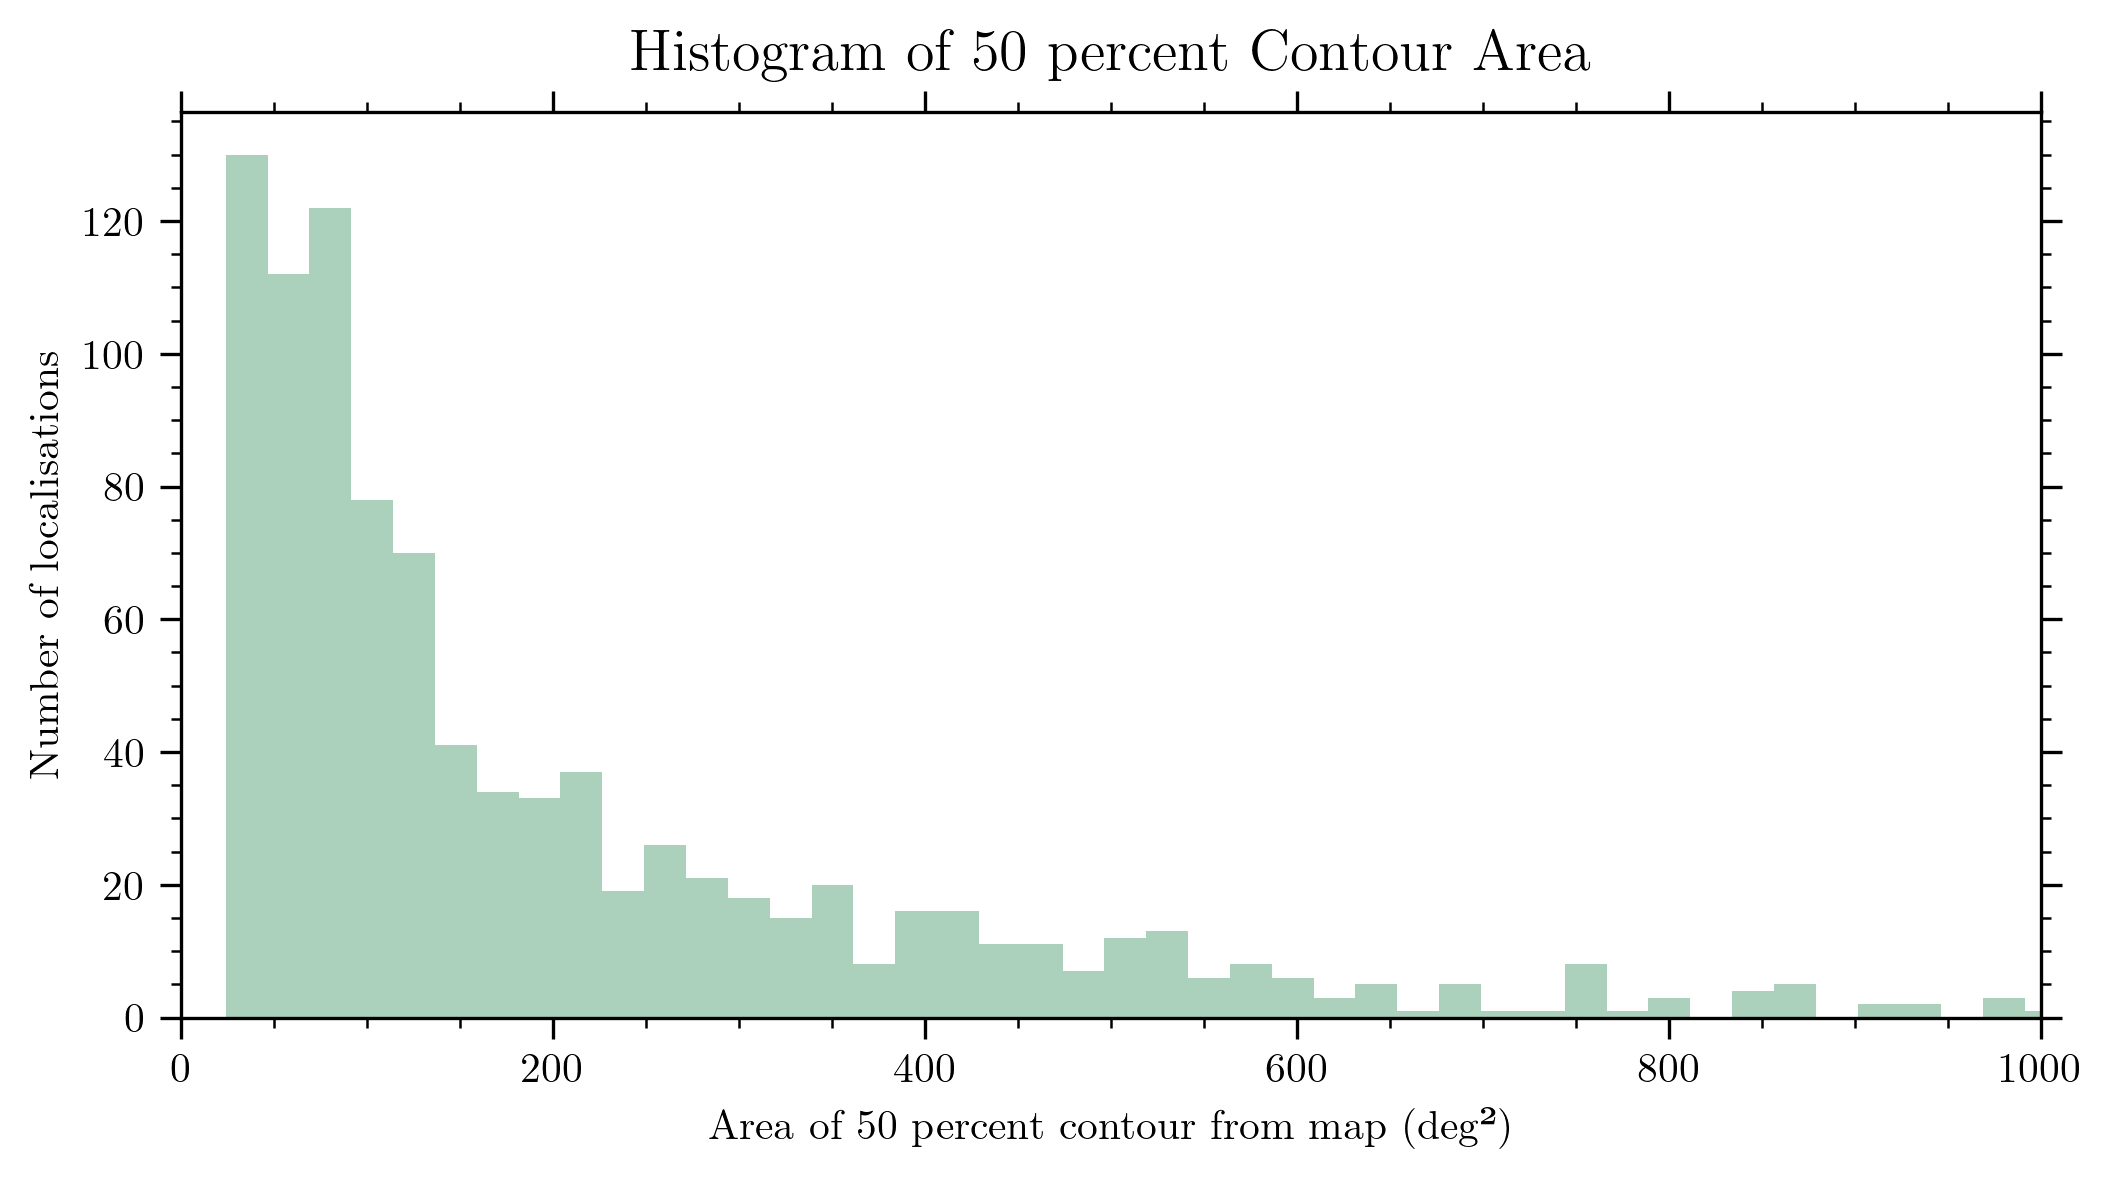

In [17]:
plt.figure(figsize=(8,4), dpi=300)
plt.hist(coverage['area'], bins=250, color='seagreen', alpha=0.4)
plt.xlabel("Area of 50 percent contour from map (deg²)")
plt.ylabel("Number of localisations")
plt.title("Histogram of 50 percent Contour Area", fontsize=14, pad=10)
plt.xlim(0,1000)
plt.show()

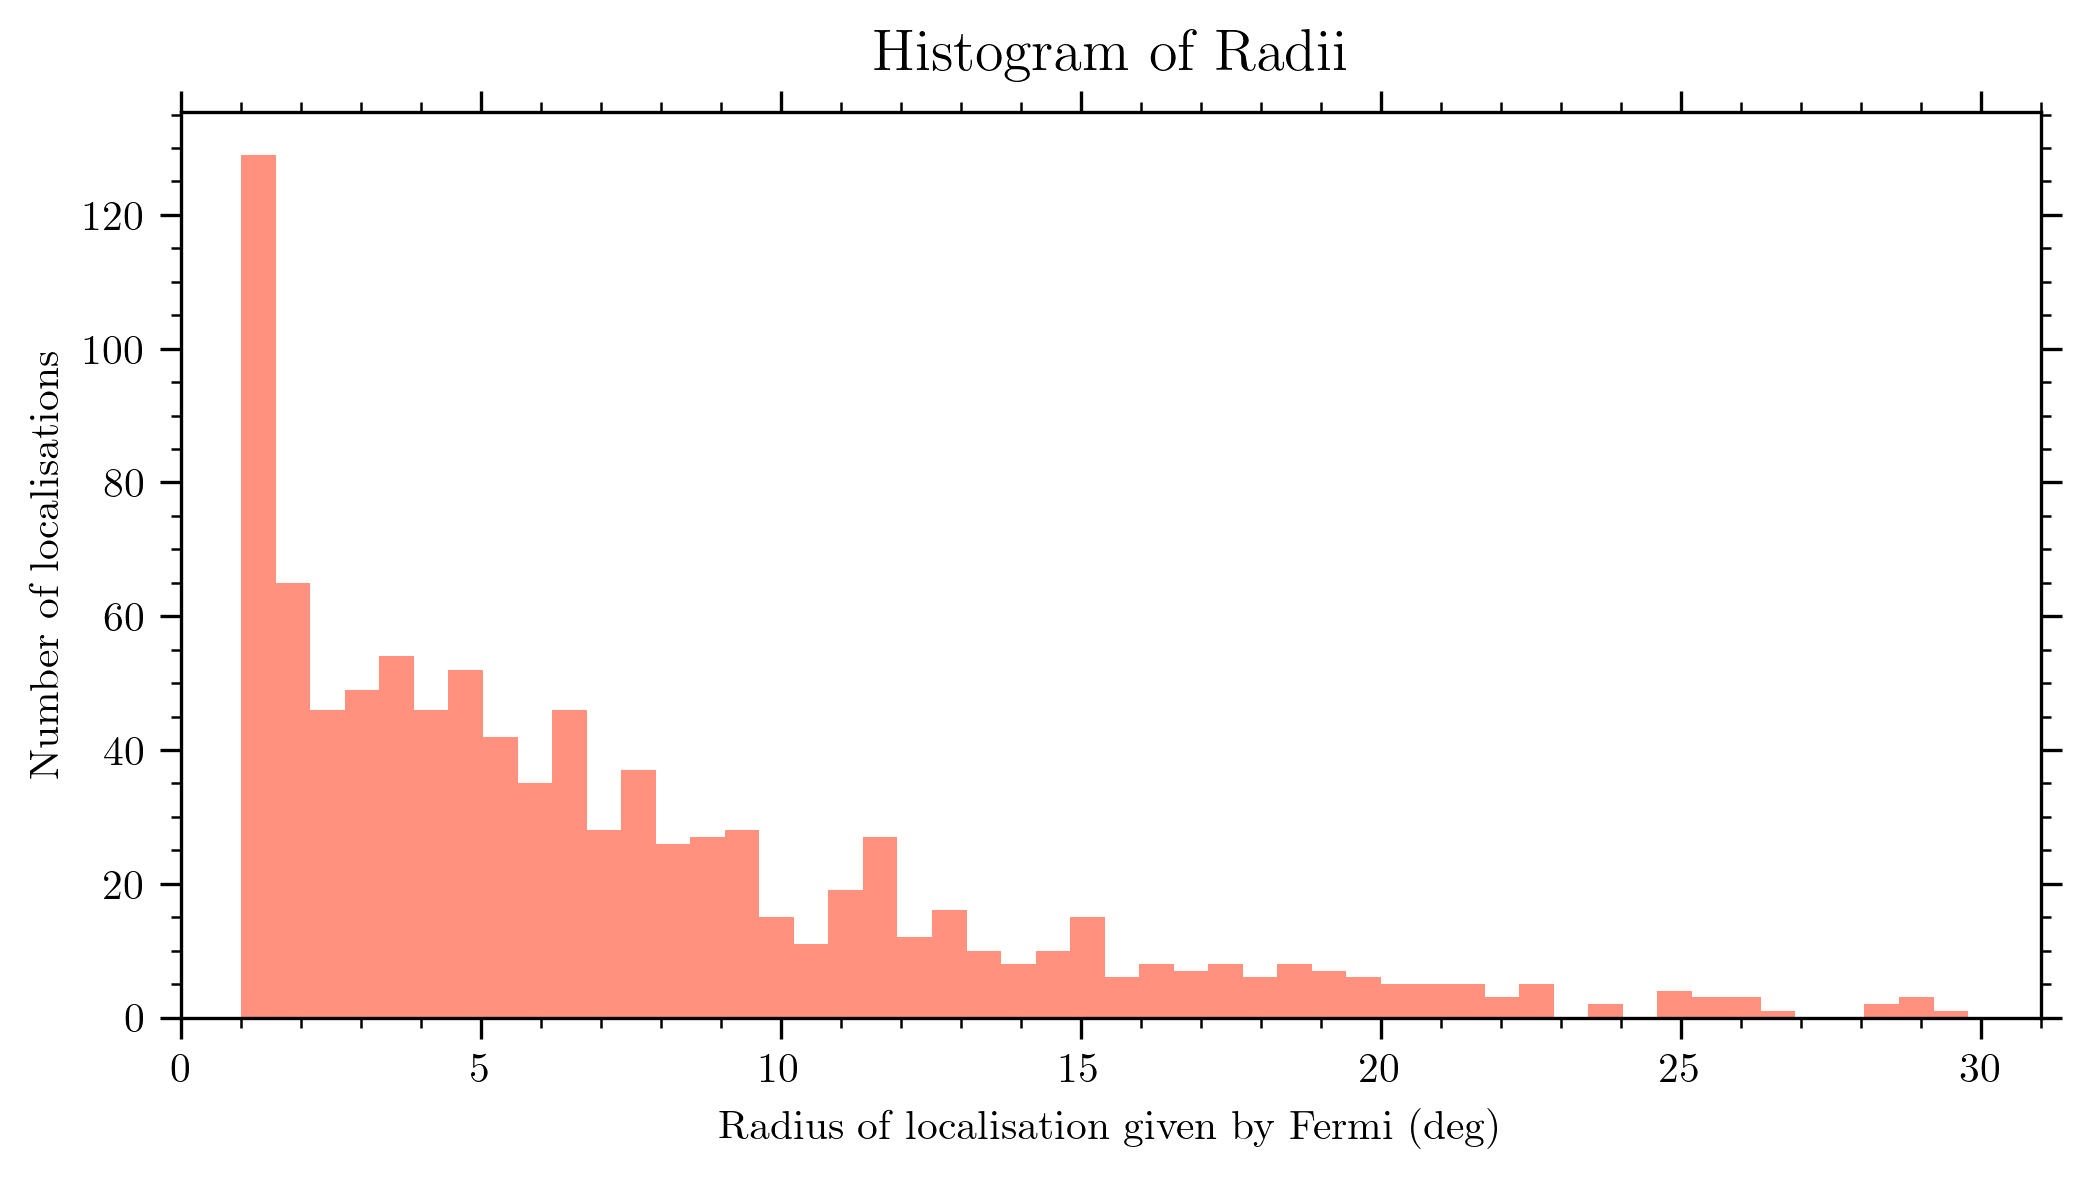

In [18]:
plt.figure(figsize=(8,4), dpi=300)
plt.hist(coverage['radius'], bins=50, color='tomato', alpha=0.7)
plt.xlabel("Radius of localisation given by Fermi (deg)")
plt.ylabel("Number of localisations")
plt.title("Histogram of Radii", fontsize=14, pad=10)
plt.xlim(0,31)
plt.show()

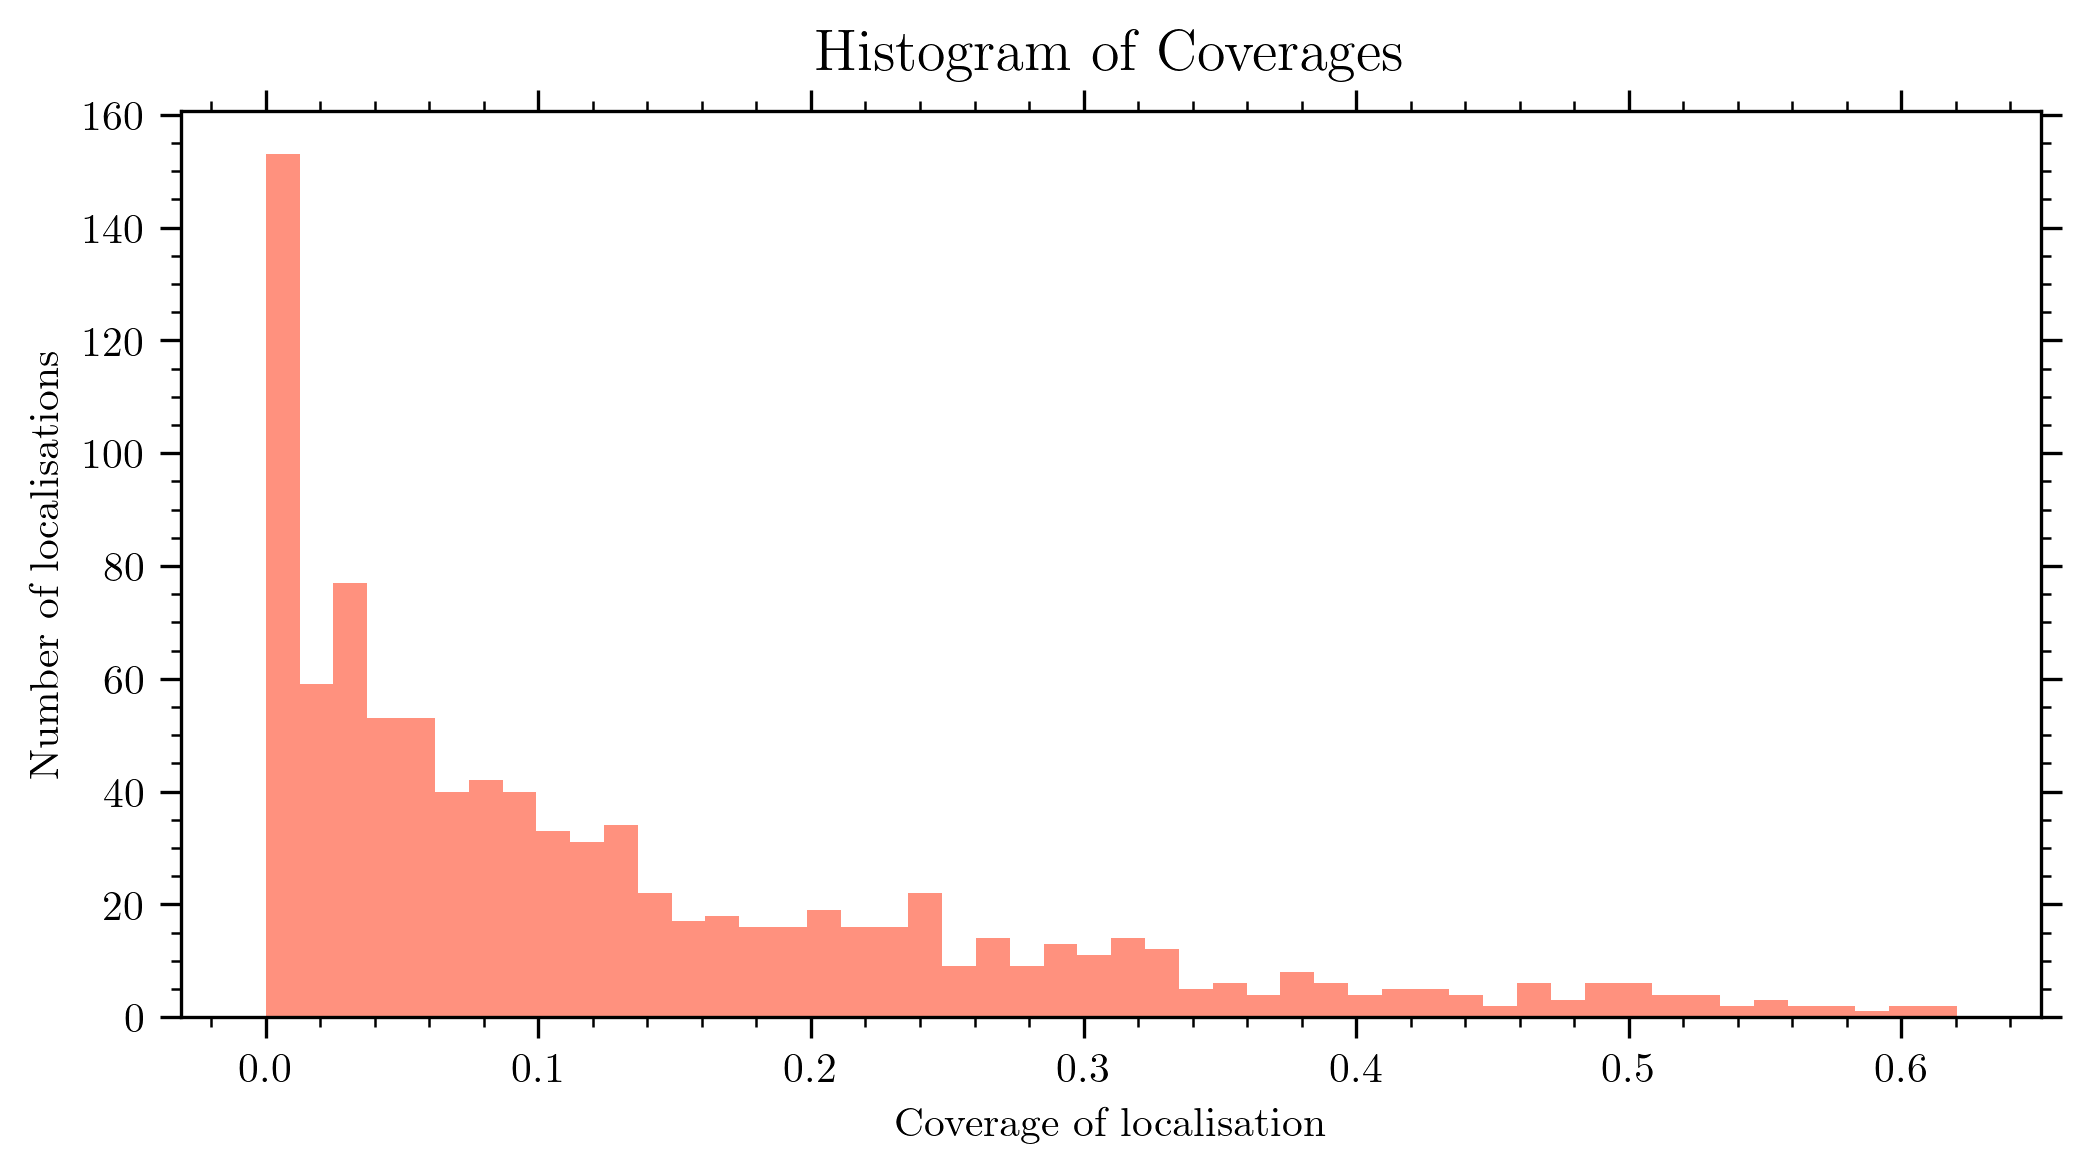

In [19]:
plt.figure(figsize=(8,4), dpi=300)
plt.hist(coverage['coverage'], bins=50, color='tomato', alpha=0.7)
plt.xlabel("Coverage of localisation")
plt.ylabel("Number of localisations")
plt.title("Histogram of Coverages", fontsize=14, pad=10)
plt.show()

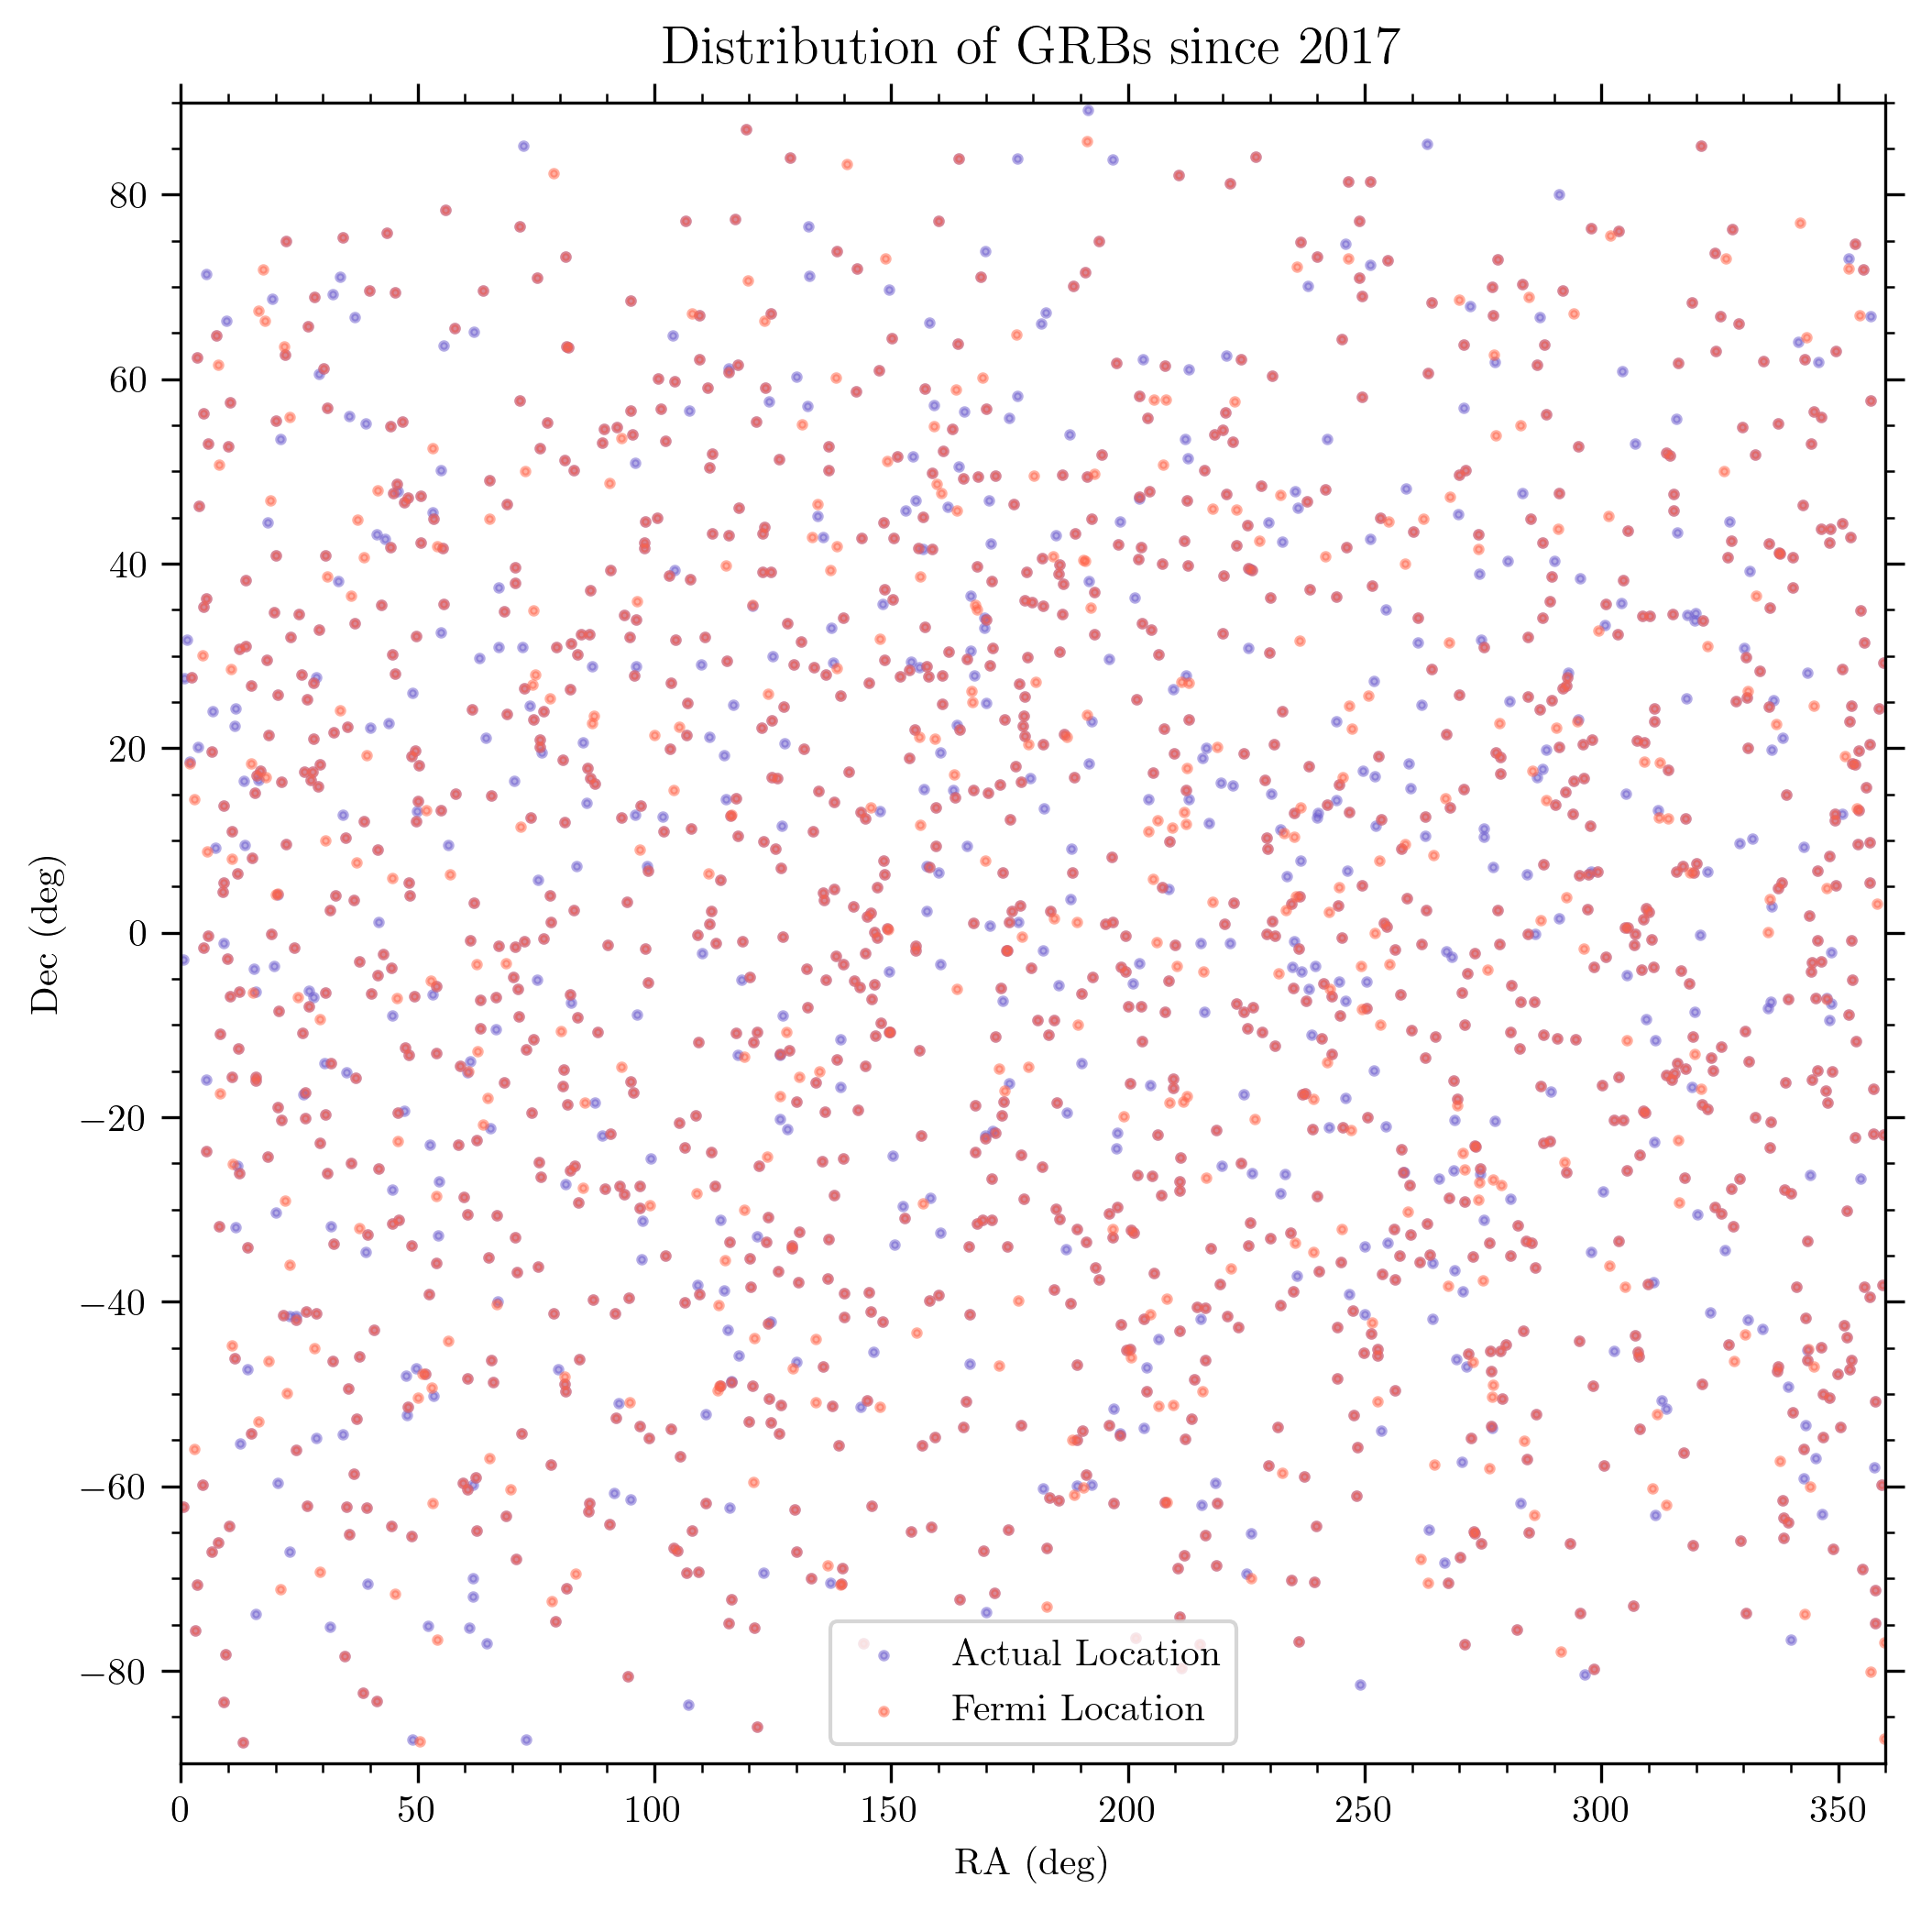

In [20]:
diff = []
ra_fermi, dec_fermi = [], []
for real_name in grb_with_prob:
    ra_real, dec_real = all_grbs[all_grbs['trigger_name']==real_name]['ra'].values[0], all_grbs[all_grbs['trigger_name']==real_name]['dec'].values[0]
    real_trigger = np.unique(u_triggers[u_triggers['url'].str.contains(real_name)]['trigger_no'].values)[0]
    ra, dec = all_triggers[all_triggers['TrigNum']==real_trigger]['RA (J2000) [deg]'].values[0], all_triggers[all_triggers['TrigNum']==real_trigger]['Dec (J2000) [deg]'].values[0]
    c1 = SkyCoord(ra=ra_real*u.degree, dec=dec_real*u.degree, frame='icrs')
    c2 = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    ra_fermi.append(ra)
    dec_fermi.append(dec)
    diff.append(c1.separation(c2).degree)
diff = np.array(diff)
ra_real, dec_real = all_grbs['ra'].values, all_grbs['dec'].values
plt.figure(figsize=(8,8), dpi=300)
plt.scatter(ra_real, dec_real, s=4, color='slateblue', alpha=0.5, label="Actual Location")
plt.scatter(ra_fermi, dec_fermi, s=4, color='tomato', alpha=0.5, label="Fermi Location")
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Distribution of GRBs since 2017", fontsize=14, pad=10)
plt.legend()
plt.xlim(0,360)
plt.ylim(-90,90)
plt.show()

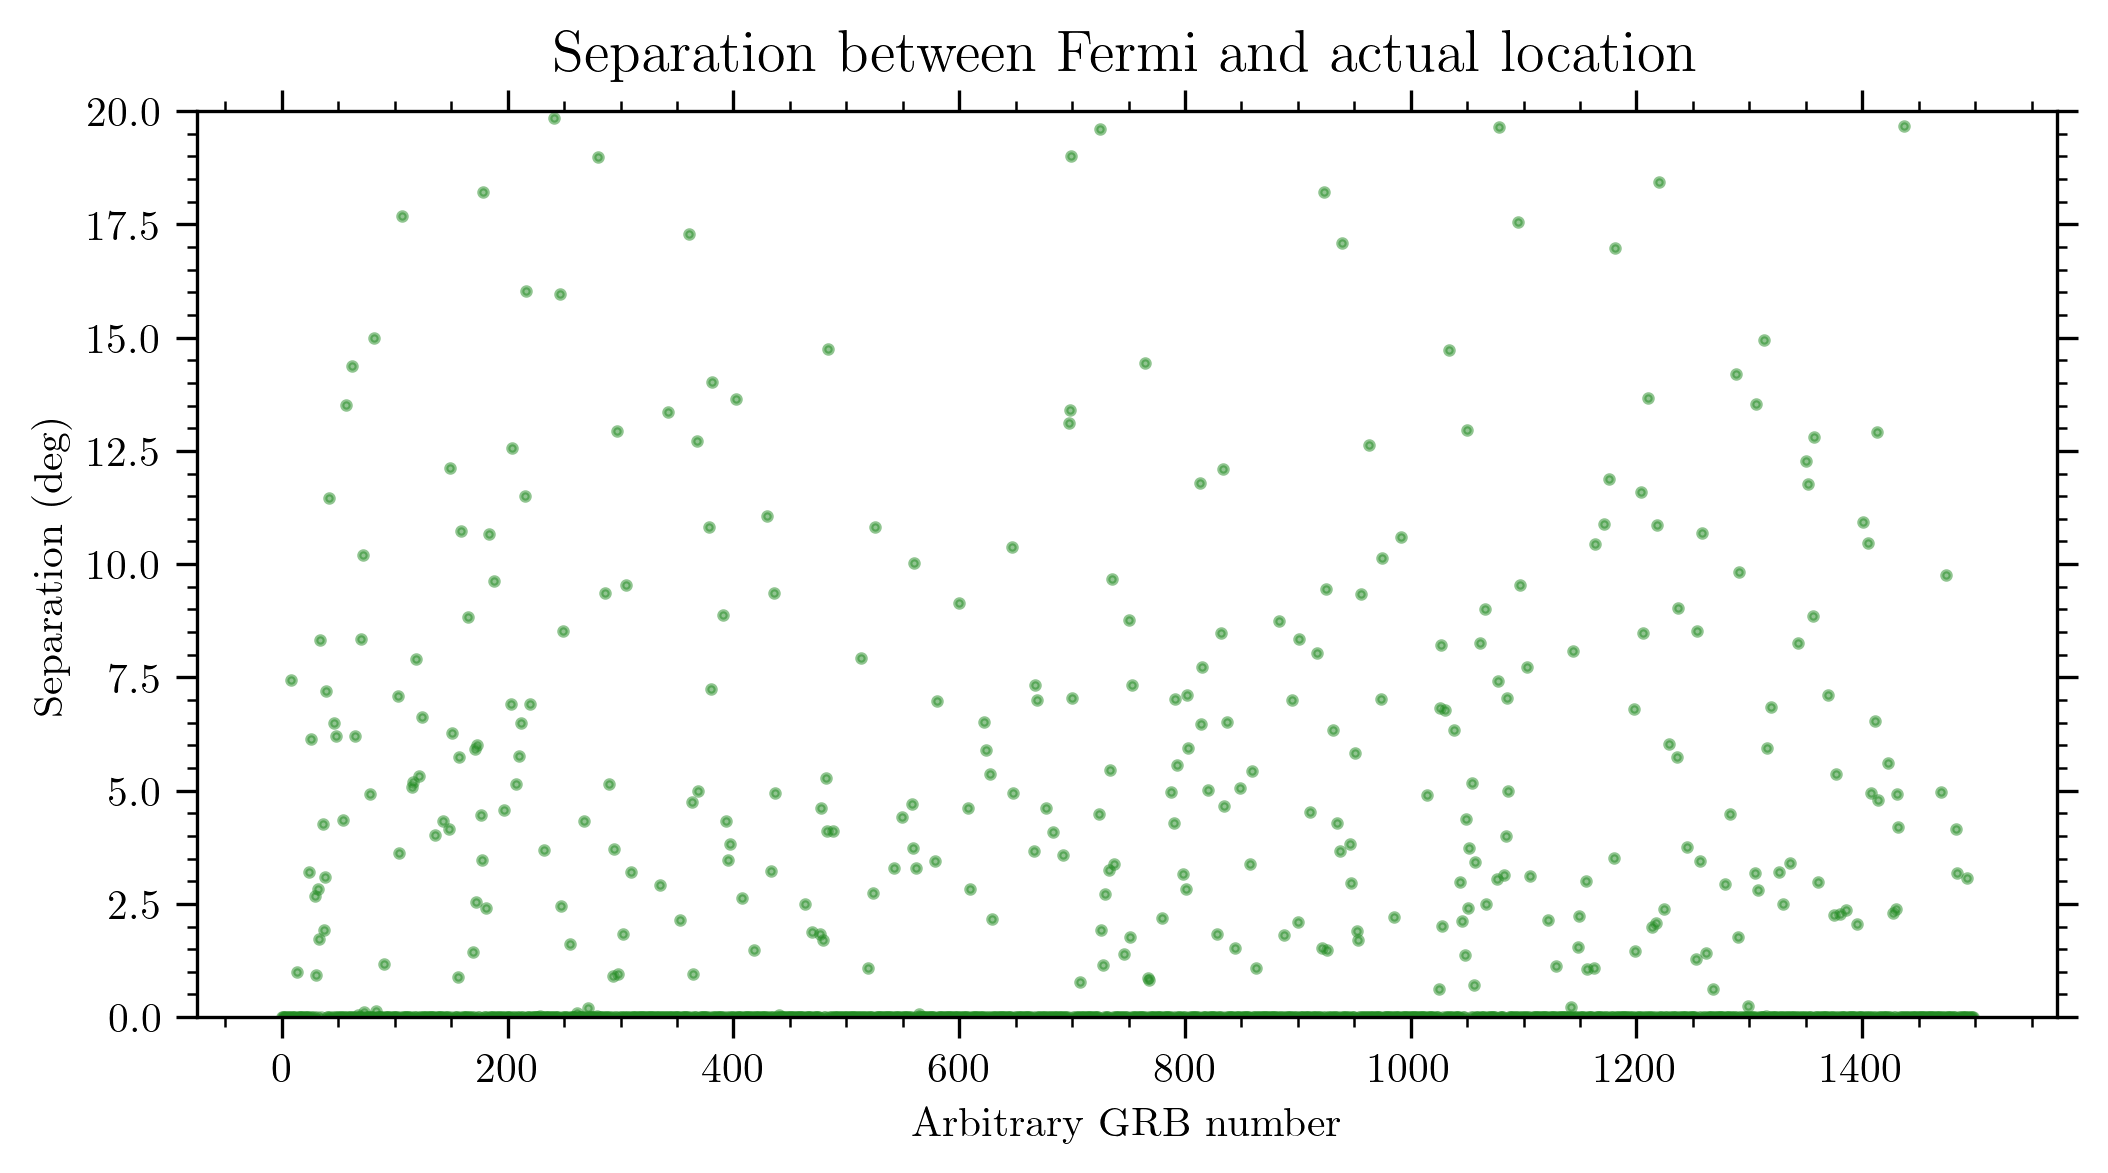

351


In [21]:
plt.figure(figsize=(8,4), dpi=300)
plt.scatter(np.arange(len(diff)),diff, color='forestgreen', alpha=0.5, s=4)
plt.xlabel("Arbitrary GRB number")
plt.ylabel("Separation (deg)")
plt.title("Separation between Fermi and actual location", fontsize=14, pad=10)
plt.ylim(0,20)
plt.show()
print(len(diff[diff>0]))

323


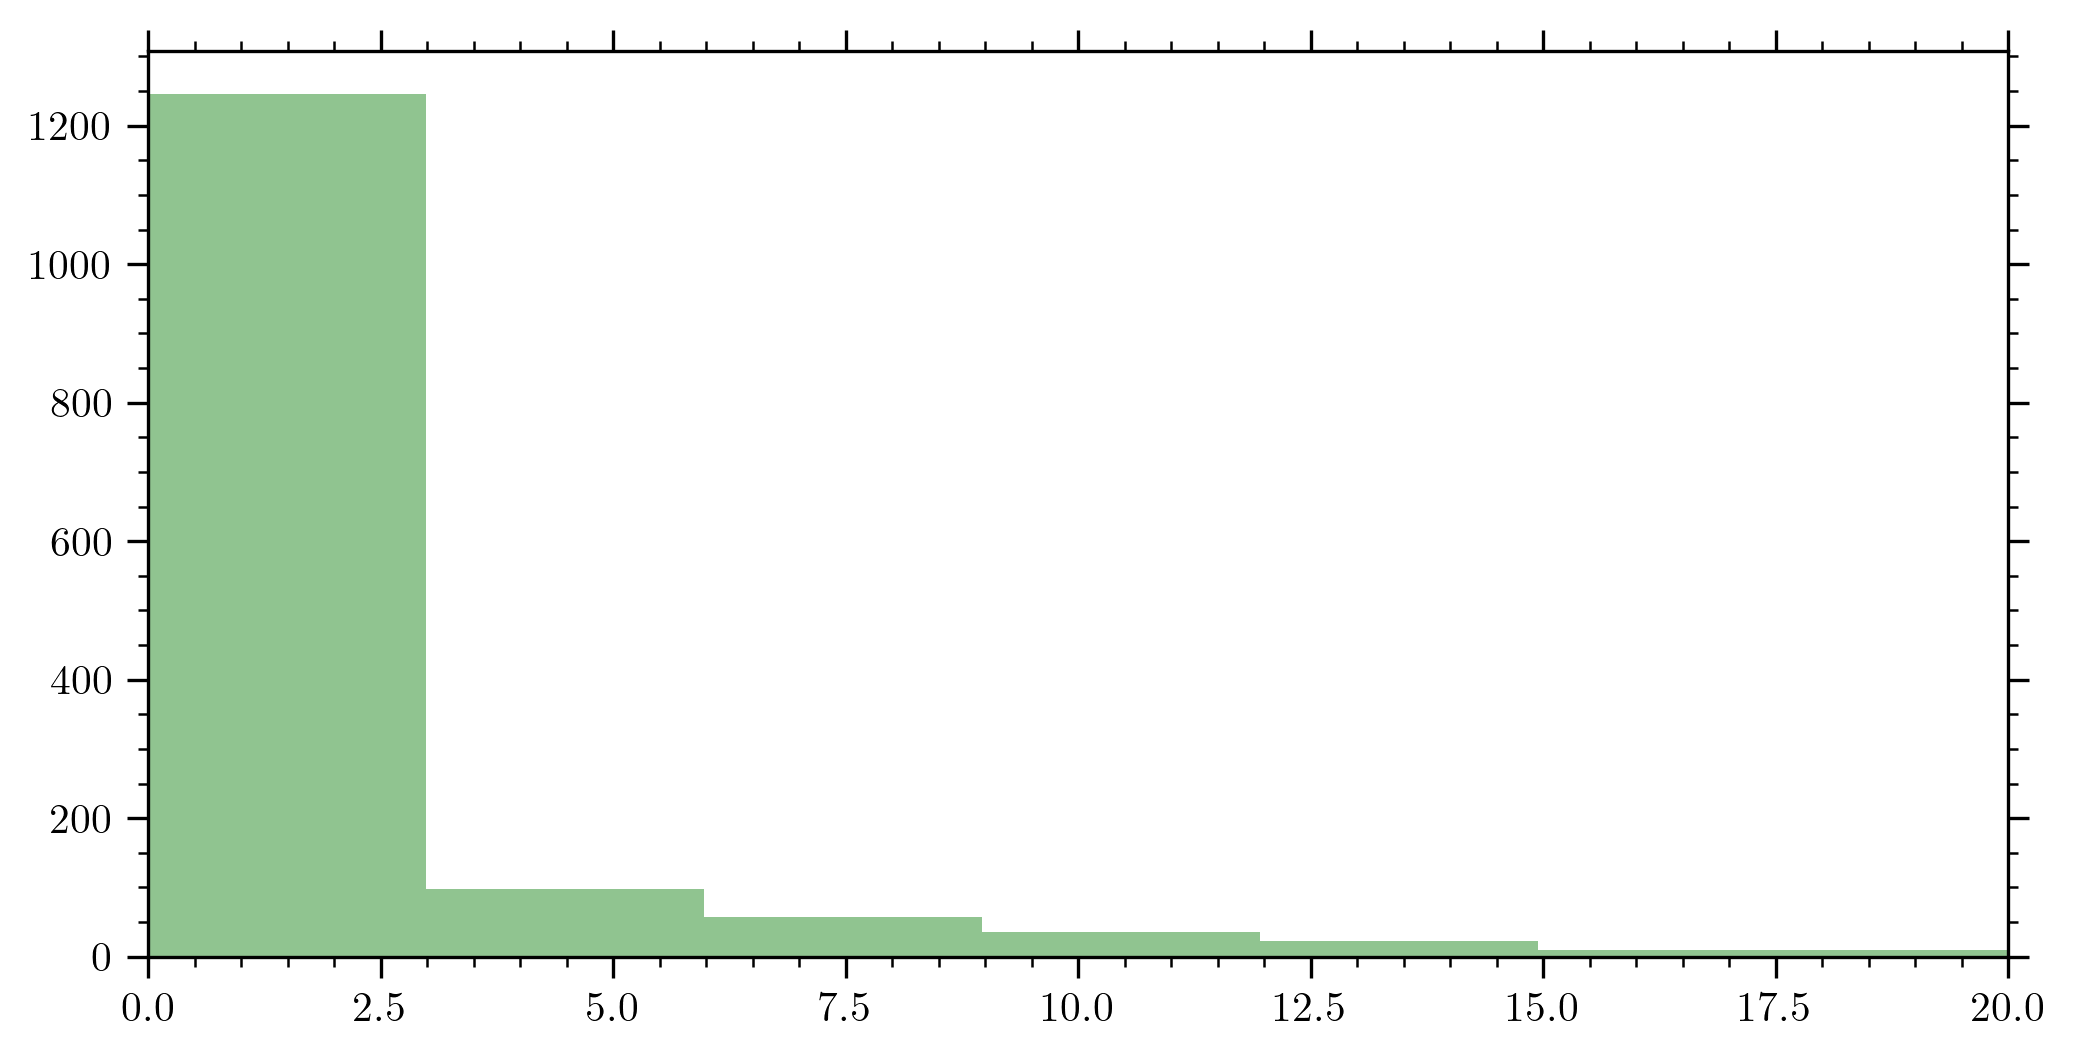

In [25]:
plt.figure(figsize=(8,4), dpi=300)
plt.hist(diff, bins=50, color='forestgreen', alpha=0.5)
plt.xlim(0, 20)
print(np.sum(diff > 1))

512
<SkyCoord (ICRS): (ra, dec) in deg
    (42.1875, -30.95220853)>
3145728


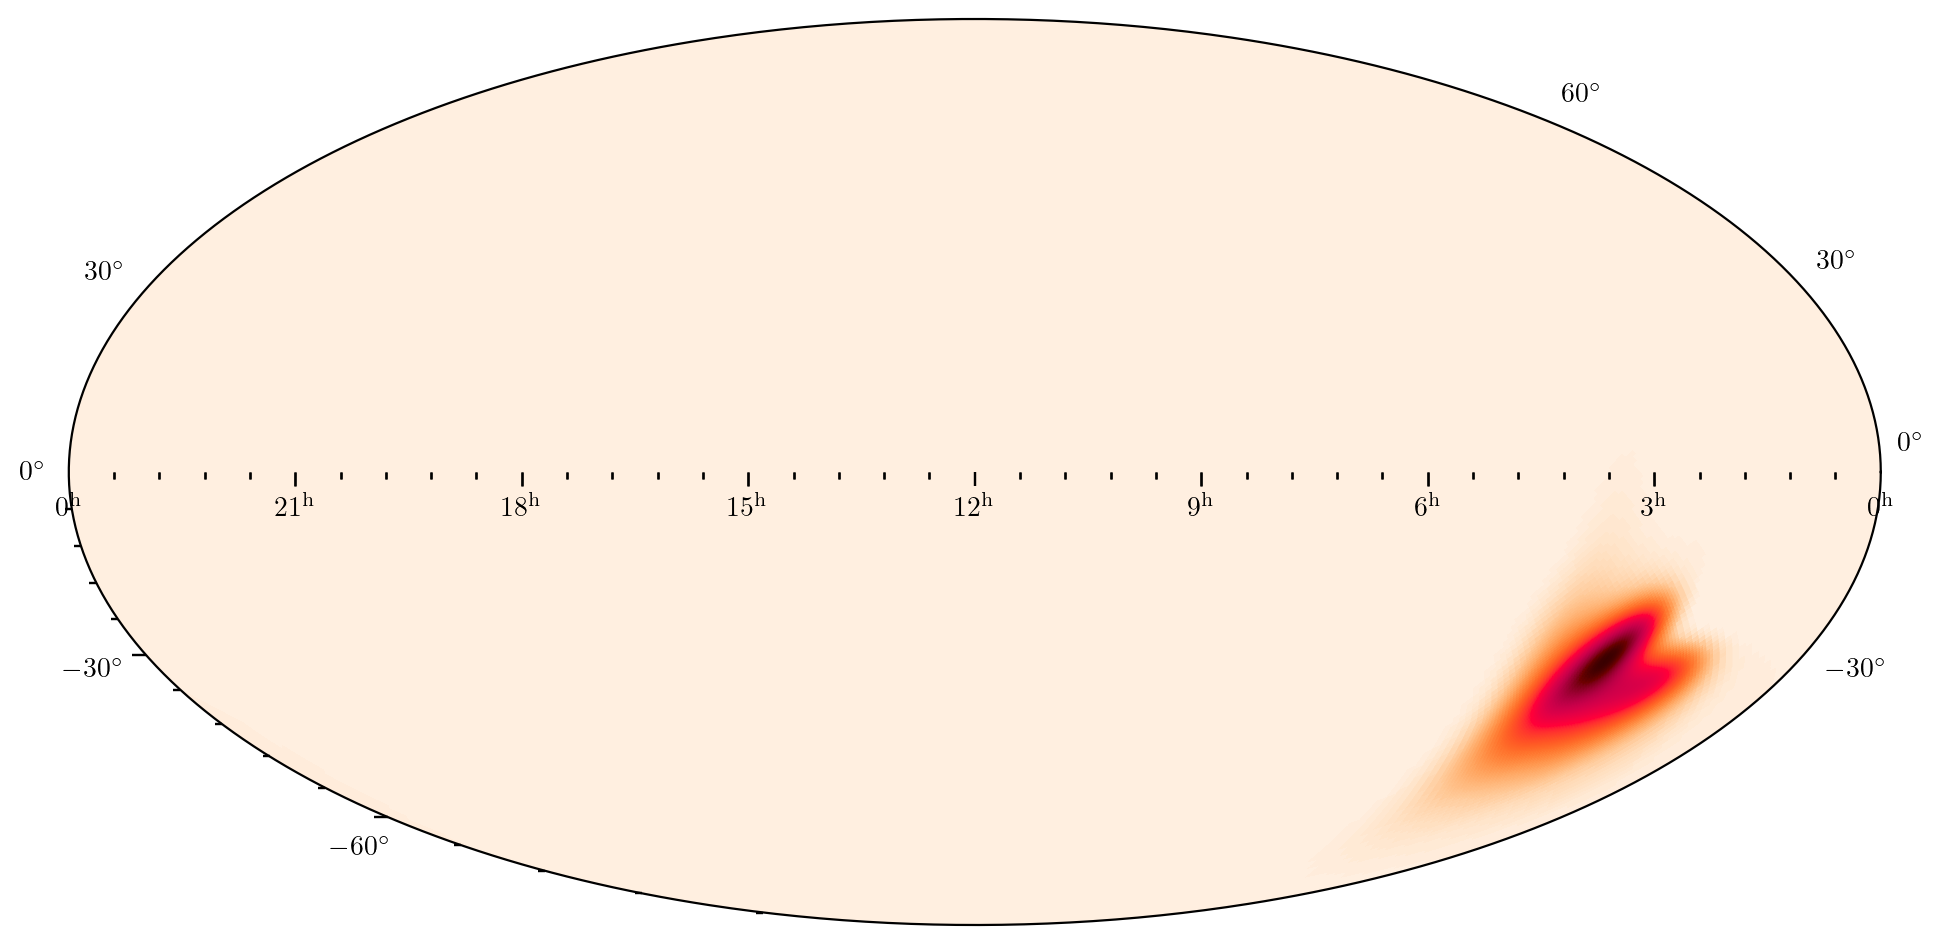

In [22]:
skymap = read_sky_map("/home/ravioli/astro/bayestar.multiorder.fits,1", moc=False)
hpmap = skymap[0]
sortorder = np.argsort(hpmap)[::-1]
print(hp.get_nside(hpmap))
print(SkyCoord(ra=hp.pix2ang(512, np.argmax(hpmap), lonlat=True)[0], dec=hp.pix2ang(512, np.argmax(hpmap), lonlat=True)[1], frame='icrs', unit='deg'))
# hpmap[sortorder[:np.where(np.cumsum(hpmap[sortorder])/np.sum(hpmap)>0.1)[0][0]]] = 1
print(len(hpmap))
fig, axes = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'projection': 'astro hours mollweide'}, dpi=200)
axes.imshow_hpx(hpmap, cmap='cylon')